<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [46]:
import random
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.setrecursionlimit(10000)


class G:
    ITERATIONS = 100
    DURATIONS = 6120

    
G.target_times = {
    1: 2,
    2: 3,
    3: 5
}


def update_target_times(target_times):
    G.target_times = {
        1: target_times[0],
        2: target_times[1],
        3: target_times[2]
    }

    
G.specialties = {
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    5: '5'
}


def update_globals(urg_times):
    G.process_times = {
                        1: urg_times[0],
                        2: urg_times[1],
                        3: urg_times[2]
                    }
    
    

def create_arrival_times(sim_time, arr_rates):
    arrival_times_dict = {}
    arrival_times_tuples_list = []
    #Create arrival times for each urgency of images
    urg = 1
    for arr_time in arr_rates:
        arrival_times = []
        time = 0
        while time < sim_time:
            time += np.random.exponential(arr_time)
            arrival_times.append(time)
            arrival_times_tuples_list.append([urg, time])
        arrival_times_dict[urg] = arrival_times
        urg += 1
    arrival_times_tuples_list = sorted(arrival_times_tuples_list, key=lambda x: x[1])
    return arrival_times_dict, arrival_times_tuples_list


def create_medical_images(arrival_times_tuples_list):
    med_images = []
    for img_id, tup in enumerate(arrival_times_tuples_list):
        med_images.append(MedicalImage(img_id, tup[1], tup[0], random.sample(list(G.specialties.keys()), 1)[0]))
    print(f"{len(med_images)} medical images")
    return med_images


def create_constant_rads(num_rads):
    specialties_list = []
    for i in range(num_rads):
        specialties_list.append(random.sample(list(G.specialties.keys()), random.randrange(2,len(G.specialties))))
    G.const_specialities = specialties_list

    
def create_radiologists(num_rads, constant_rads):
    radiologists = []
    for i in range(num_rads):
        if constant_rads:
            specialties_temp = G.const_specialities[i] 
        else:
            specialties_temp = random.sample(list(G.specialties.keys()), random.randrange(2,len(G.specialties)))
        radiologists.append(Radiologist(i, specialties_temp))
    return radiologists


def create_initial_events(sim_duration, med_images, cutoff=False):
    events=[]
    for img in med_images:
        events.append([img.time_created, 'New Job', img])
    if cutoff:
        events.append([sim_duration*2, "Sim End"])
    events = sorted(events, key=lambda x: x[0])
    return events


def start_simulation(events, med_images, radiologists, constant_rads, cutoff=False):
    s = SystemState(events, med_images, G.radiologists, cutoff)
    s.run_simulation()


class MedicalImage(object):    
    def __init__(self, img_id, time_created, urgency, image_type):#, modality, speciality, urgency, image_label):
        self.img_id = img_id
        self.time_created = time_created
        self.urgency = urgency
        self.image_type = image_type
        self.target_time = G.target_times[urgency]
        self.time_remaining = G.target_times[urgency]
        self.est_process_time = G.process_times[urgency]
        self.in_queues = []   #keep track on which queues image is in [rad_id, position]
        self.time_seen = 0
        self.time_done = 0
        self.rad_seen = "None"
        
    def update_time_remaining(self, t):
        self.time_remaining = self.target_time - (t - self.time_created)
        
        
class Radiologist:
    def __init__(self, rad_id, specialties, working=True):
        self.queue = []
        self.queue_data = []#[med_image, image_id, image_urgency, time_left, est_time]
        self.rad_id = rad_id
        self.specialties = specialties
        self.is_working = working
        self.is_idle = 1
        self.images_served = []
        self.idle_times = []
        self.time_busy_start = 0
        self.time_idle_start = 0
        self.busy_times = []
        self.time = 0
        self.time_of_step = 0
        self.queue_length = []
        self.service_starts = []
        self.service_ends = []
        self.service_time = []  
        
    def get_stats(self):
        return self.idle_times, self.busy_times, self.queue_length, self.service_starts, self.service_ends, self.service_time 
        
    def show_queue(self):
        return self.queue
    
    def estimate_queue_time(self):
        t = 0
        for img in self.queue:
            t += img.est_process_time
        return t
    
    def add_job(self, med_image, time):
        #update idle time tracker
        if self.is_idle == 1:
            self.idle_times.append(time - self.time_idle_start)
            self.time_busy_start = time
        self.is_idle = 0
        #add img to queue and sort
        #self.queue.append(med_image)
        #if len(self.queue) > 1:
        #    self.sort_queue()
        if len(self.queue) <= 1:
            self.queue.append(med_image)
            self.queue_data.append([med_image, med_image.img_id, med_image.urgency, med_image.time_remaining, med_image.est_process_time, med_image.est_process_time]) #[image_id, image_urgency, time_left, est_time]
        else:
            if med_image.urgency == 1:
                ins_ind = 1
                for ind, img in enumerate(self.queue[1:]):
                    if img.urgency > 1:
                        ins_ind = ind + 1
                        break          
                self.queue.insert(ins_ind, med_image)
            elif med_image.urgency == 2:
                ins_ind = 1
                for ind, img in enumerate(self.queue[1:]):
                    if img.urgency > 2:
                        ins_ind = ind + 1
                        break          
                self.queue.insert(ins_ind, med_image)
            else:
                self.queue.append(med_image)

    def sort_queue(self):
        curr_img = self.queue[0]
        queue_tuple = [[img, img.urgency] for img in self.queue[1:]]
        queue_tuple = sorted(queue_tuple, key=lambda x: x[1])
        #print(queue_tuple)
        queue_tuple_list = [tup[0] for tup in queue_tuple]
        self.queue = queue_tuple_list
        self.queue.insert(0, curr_img)
       
    def finish_job(self, time):
        if len(self.queue) == 0:
            self.time_finished_last_job = time
            self.time_idle_start = time
            self.busy_times.append(time - self.time_busy_start)
            self.is_idle = 1
    
    def update_idle_lists(self, time):
        if self.is_idle == 1:
            self.idle_times.append(time - self.time_idle_start)
        elif self.is_idle == 0:
            self.busy_times.append(time - self.time_busy_start)
        
    def update_queue(self, time):
        for img in self.queue:
            img.update_time_remaining(time)
        #sort_queue()        
    #def sort_queue(self):
                   
        
        
class SystemState:
    def __init__(self, sim_duration, events, images, rads, cutoff=False, verbose=False):
        self.time = 0
        self.sim_duration = sim_duration
        self.continue_running = True
        self.events = events
        self.images = images
        self.rads = rads
        self.rads_working = rads
        self.rads_not_working = []
        self.events_history = []
        self.queue_lengths = []
        self.time_steps = []
        self.img_table = pd.DataFrame(columns=['img_id','urgency', 'create_time','seen_time', 'finished', 'img_wait_time', 'time_w_rad', 'total_time'])
        self.rad_table = pd.DataFrame()
        self.unfin_img_table = pd.DataFrame(columns=['img_id','urgency', 'create_time','seen_time', 'finished', 'img_wait_time', 'time_w_rad', 'total_time'])
        self.verbose = verbose
        
    def create_event(self, time, event_type, obj):
        self.events.append([time, event_type, obj])
        self.events = sorted(self.events, key=lambda x: x[0])

    def update_img_table(self, med_img):
        column_names = ['img_id','urgency', 'create_time','seen_time', 'finished','img_wait_time', 'time_w_rad', 'total_time']
        values = [med_img.img_id, med_img.urgency, med_img.time_created, med_img.time_seen, self.time, med_img.time_seen - med_img.time_created, self.time - med_img.time_seen, self.time - med_img.time_created] #[[med_img.time_created], [med_img.time_seen], [self.time], [self.time - med_img.time_seen], [self.time - med_img.time_created]]
        temp_df = pd.DataFrame(values).T
        temp_df.columns = column_names
        self.img_table = self.img_table.append(temp_df, ignore_index = True)
        
    def unfinished_jobs(self):
        unfin_med_images = []
        for rad in self.rads:
            unfin_med_images += rad.queue
            unfin_med_images = list(set(unfin_med_images))
        print(f"There are {len(unfin_med_images)} that were not completed in time")
        column_names = ['img_id','urgency', 'create_time','seen_time', 'finished','img_wait_time', 'time_w_rad', 'total_time']
        for med_img in unfin_med_images:
            values = [med_img.img_id, med_img.urgency, med_img.time_created, med_img.time_seen, self.time, med_img.time_seen - med_img.time_created, self.time - med_img.time_seen, self.time - med_img.time_created] #[[med_img.time_created], [med_img.time_seen], [self.time], [self.time - med_img.time_seen], [self.time - med_img.time_created]]
            temp_df = pd.DataFrame(values).T
            temp_df.columns = column_names
            self.unfin_img_table = self.unfin_img_table.append(temp_df, ignore_index = True)
        
    def process_event(self):
        event = self.events[0]
        self.events_history.append(event)
        self.time = event[0]       
        event_type = event[1]
        del self.events[0]
        temp_list = []
        for r in self.rads:
            temp_list.append(len(r.queue))
        self.queue_lengths.append(temp_list)
        self.time_steps.append(self.time)
        
            
        if event_type == "New Job":
            self.distribute_job(event[2])
        elif event_type == "Job Done":
            rad = event[2]
            self.complete_job(rad)
        elif event_type == "Sim End":
            self.continue_running = False 
        if self.verbose==True:
            print("Event processed")
        if (len(self.events) == 0) or (self.events[0][1]=="Sim End"):
            self.continue_running = False 
        if self.continue_running:
            self.process_event()
        else:
            for rad in self.rads:
                rad.update_idle_lists(self.time)
            self.unfinished_jobs()
            print(f"Simulation complete at {self.time} minutes")
                
    def distribute_job(self, med_image):
        urgency = med_image.urgency
        image_type = med_image.image_type
        chosen_rads = self.choose_rads(image_type)       
        for rad in chosen_rads:
            rad.add_job(med_image, self.time)
            med_image.in_queues.append(rad)    #keep track of which rads have image in queue
            if len(rad.queue)==1:
                self.start_job(rad)
                break         
        self.update_queues() 
        
    def choose_rads(self, image_type):
        capable_rads = []
        for rad in self.rads_working:      #finds radiologists capable of working on image
            if image_type in rad.specialties:
                capable_rads.append(rad)
        chosen_rads = self.n_quickest_queues(capable_rads, 3)
        return capable_rads
    
    def n_shortest_queues(self, rads_list, n):
        rads_tuples = []
        for rad in rads_list:
            rads_tuples.append([rad, len(rad.queue)])
        rads_tuples.sort(key = lambda x: x[1])
        return [rad[0] for rad in rads_tuples[:n]]
    
    def n_quickest_queues(self, rads_list, n):
        rads_tuples = []
        for rad in rads_list:
            rads_tuples.append([rad, rad.estimate_queue_time()])
        rads_tuples.sort(key = lambda x: x[1])
        return [rad[0] for rad in rads_tuples[:n]]
             
    def update_queues(self):
        for rad in self.rads_working:
            rad.update_queue(self.time)
                
    def start_job(self, rad):
        med_image = rad.queue[0]
        image_type = med_image.image_type
        urgency = med_image.urgency
        rad.service_starts = self.time
        med_image.time_seen = self.time
        med_image.rad_seen = rad.rad_id
        self.events_history.append([self.time, "Job Started", med_image])
        process_time = np.random.exponential(G.target_times[urgency])
        self.create_event(self.time+process_time, "Job Done", rad)
        if self.verbose==True:
            print(f"Image {med_image.img_id} is seen by radiologist {rad.rad_id} at {self.time}")
        for r in med_image.in_queues:
            if r != rad:
                r.queue.remove(med_image)           
        
    def complete_job(self, rad):
        med_image = rad.queue[0]
        self.update_img_table(med_image)
        rad.images_served.append(med_image.img_id)
        rad.service_ends.append(self.time)
        med_image.time_done = self.time
        if self.verbose==True:
            print(f"Image {med_image.img_id} is done by radiologist {rad.rad_id} at {self.time}")
        del rad.queue[0]
        rad.finish_job(self.time)
        if len(rad.queue) > 0:
            self.start_job(rad)

    def run_simulation(self):
        self.process_event()

In [64]:
def gen_system_state(sim_time, rads_count, arr_rates, urg_times, constant_rads, cutoff, verbose):
    #Define urgency times
    update_globals(urg_times)
    #Create the intervals
    arrivals_dict, arrival_times_tuples_list = create_arrival_times(sim_time, arr_rates)
    #Create the images with their arrival time_seen
    med_images = create_medical_images(arrival_times_tuples_list)
    #Create the radiologists
    radiologists = create_radiologists(rads_count, constant_rads)
    #Create the image arrival events
    events = create_initial_events(sim_time, med_images, cutoff)
    s = SystemState(sim_time, events, med_images, radiologists, cutoff, verbose)
    return s


def sim(sim_time, rads_count, arr_rates, urg_times, constant_rads=False, cutoff=False, verbose=False):  
    s = gen_system_state(sim_time, rads_count, arr_rates, urg_times, constant_rads, cutoff, verbose)
    s.run_simulation()    
    return s


def plot_queue_lengths(s):
    fig, ax = plt.subplots()
    for i in range(len(s.queue_lengths[0])):
        plt.plot(s.time_steps, [item[i] for item in s.queue_lengths])

        
def wait_time_plot(img_table):
    fig, ax = plt.subplots()
    x = img_table['create_time'].values
    y = img_table['img_wait_time'].values
    colormap = {
        1: "red",
        2: "orange",
        3: "green"
               }
    colors_list = img_table['urgency'].map(colormap)
    plt.scatter(x, y, color=colors_list, alpha=.6)
    plt.xlabel("Time Job Begins")
    plt.ylabel("Time Until Job Seen")   
    plt.title("Time Before Job is Seen")
    red_patch = mpatches.Patch(color='red', alpha=.8, label='Urgency 1')
    orange_patch = mpatches.Patch(color='orange', alpha=.8, label='Urgency 2')
    green_patch = mpatches.Patch(color='green', alpha=.8, label='Urgency 3')
    plt.legend(handles=[red_patch, orange_patch, green_patch])
    plt.show()
    

def total_time_plot(img_table):
    x=img_table['create_time'].values
    y=img_table['total_time'].values
    plt.scatter(x, y)
    
        
def plt_mean_queue_length(s_list):
    fig, ax = plt.subplots()
    for s in s_list:
        plt.plot(s.time_steps, pd.DataFrame(s.queue_lengths).sum(axis=1), label=f"{len(s.rads)}")
    plt.xlabel("time")
    plt.ylabel("Mean Queue Length")
    plt.legend()
    plt.show()
    

def rad_idle_plot(rad):
    idle_times = rad.idle_times
    busy_times = rad.busy_times
    left_var = 0
    for i in range(len(idle_times)):
        plt.barh(rad.rad_id, idle_times[i], left=left_var, color="red")
        left_var = left_var + idle_times[i]
        if i < len(busy_times):
                plt.barh(rad.rad_id, busy_times[i], left=left_var, color="orange")
                left_var = left_var + busy_times[i]

    plt.legend(["idle", "busy"], title="Idle Times", loc="upper right")
    plt.show()
    
    
def idle_plots(rads):
    plot_list = {}
    total_idle = 0
    total_busy = 0
    avg_busy_times = {}
    for rad in rads:
        idle_times = rad.idle_times
        busy_times = rad.busy_times
        left_var = 0
        for i in range(len(idle_times)):
            plt.barh(rad.rad_id, idle_times[i], left=left_var, color="red")
            left_var = left_var + idle_times[i]
            if i < len(busy_times):
                plt.barh(rad.rad_id, busy_times[i], left=left_var, color="orange")
                left_var = left_var + busy_times[i]
        per_busy = np.sum(busy_times)/(np.sum(busy_times) + np.sum(idle_times))
        avg_busy_times[rad.rad_id] = per_busy
        total_idle += np.sum(idle_times)
        total_busy += np.sum(busy_times)
        #print(f"Radiologist {rad.rad_id} was busy {round(per_busy, 3)} of the time.")
        plt.legend(["idle", "busy"], title="Idle Times", loc="upper right")
    plt.xlabel("time")
    plt.ylabel("Radiologist ID")
    plt.show()
    
    total_per_busy = total_busy/(total_busy + total_idle)
    # Busy percent plots
    fig, ax = plt.subplots()
    plt.bar(avg_busy_times.keys(), avg_busy_times.values())
    plt.xlabel("Radiologist ID")
    plt.ylabel("Percent of Time Busy")
    plt.show()
    print(f"Radiologists were busy {round(total_per_busy,3)} of the time.")
    return total_per_busy

    
    
def total_time_hist(curr_sim):
    #all urgencies
    """""
    fig, ax = plt.subplots()
    plt.hist(curr_sim.img_table.total_time)
    plt.xlabel("time")
    plt.ylabel("Number of Images")
    plt.title("Time to be processed from creation (All Medical Images)")
    plt.show()
    """""
    
    #urgencies seperated
    fig, ax = plt.subplots()
    plt.hist(curr_sim.img_table[curr_sim.img_table.urgency==3].total_time, label=f"urgency 3: {len(curr_sim.img_table[curr_sim.img_table.urgency==3])} images", color="red", alpha=0.6)
    plt.hist(curr_sim.img_table[curr_sim.img_table.urgency==2].total_time, label=f"urgency 2: {len(curr_sim.img_table[curr_sim.img_table.urgency==2])} images", color="yellow", alpha=0.5)
    plt.hist(curr_sim.img_table[curr_sim.img_table.urgency==1].total_time, label=f"urgency 1: {len(curr_sim.img_table[curr_sim.img_table.urgency==1])} images", color="green", alpha=0.5)
    plt.xlabel("time")
    plt.ylabel("Number of Images")
    plt.title("Time to be processed from creation (All Medical Images)")
    plt.legend()
    plt.show()
    
    t1 = np.mean(curr_sim.img_table[curr_sim.img_table.urgency==1].total_time)
    t2 = np.mean(curr_sim.img_table[curr_sim.img_table.urgency==2].total_time)
    t3 = np.mean(curr_sim.img_table[curr_sim.img_table.urgency==3].total_time)
    print(f"The average total time for urgency 1, 2, and 3 medical images are:")
    print(f"Urgency 1: {t1}")
    print(f"Urgency 2: {t2}")
    print(f"Urgency 3: {t3}")
    

def wait_time_hist(curr_sim):
    #all urgencies
    """""
    fig, ax = plt.subplots()
    plt.hist(curr_sim.img_table.img_wait_time)
    plt.xlabel("time (mins)")
    plt.ylabel("Number of Images")
    plt.title("Time to be processed from creation (All Medical Images)")
    plt.show()
    """""
    
    #urgencies seperated
    fig, ax = plt.subplots()
    plt.hist(curr_sim.img_table[curr_sim.img_table.urgency==3].img_wait_time, label=f"urgency 3: {len(curr_sim.img_table[curr_sim.img_table.urgency==3])} images", color="red", alpha=0.6)
    plt.hist(curr_sim.img_table[curr_sim.img_table.urgency==2].img_wait_time, label=f"urgency 2: {len(curr_sim.img_table[curr_sim.img_table.urgency==2])} images", color="yellow", alpha=0.5)
    plt.hist(curr_sim.img_table[curr_sim.img_table.urgency==1].img_wait_time, label=f"urgency 1: {len(curr_sim.img_table[curr_sim.img_table.urgency==1])} images", color="green", alpha=0.5)
    plt.xlabel("time (mins)")
    plt.ylabel("Number of Images")
    plt.title("Time to be processed from creation (All Medical Images)")
    plt.legend()
    plt.show()
    
    t1 = np.mean(curr_sim.img_table[curr_sim.img_table.urgency==1].img_wait_time)
    t2 = np.mean(curr_sim.img_table[curr_sim.img_table.urgency==2].img_wait_time)
    t3 = np.mean(curr_sim.img_table[curr_sim.img_table.urgency==3].img_wait_time)
    print(f"The average wait time for urgency 1, 2, and 3 medical images are:")
    print(f"Urgency 1: {t1}")
    print(f"Urgency 2: {t2}")
    print(f"Urgency 3: {t3}")
    
def completion_plot(sims_dict):
    arr_rates = []
    sims_compl_rates = []
    for arr_val, sim in sims_dict.items():
        compl_num = len(sim.img_table)
        un_fin_num = len(sim.unfin_img_table)
        perc_compl = compl_num/(compl_num + un_fin_num)
        sims_compl_rates.append(perc_compl)
        arr_rates.append(arr_val)
        sim_duration = sim.sim_duration
        #print(f"Arr every {arr_val} had {perc_compl} completion.")
    # Busy percent plots
    fig, ax = plt.subplots()
    plt.scatter(arr_rates, sims_compl_rates)
    plt.xlabel("Average time between image creation (min)")
    plt.ylabel(f"Percent of Images completed in {2*sim_duration} minutes")
    plt.show()
    
    

 
**********************************************************
 
Images arrive every 0.4 minutes.
2164 medical images
There are 714 that were not completed in time
Simulation complete at 599.2149846815623 minutes


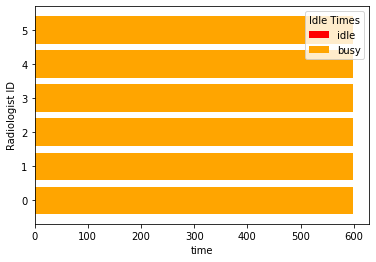

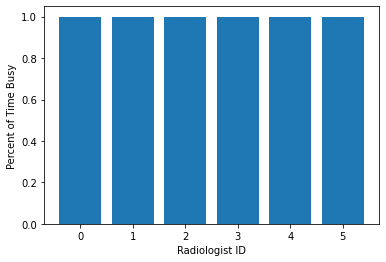

Radiologists were busy 0.999 of the time.


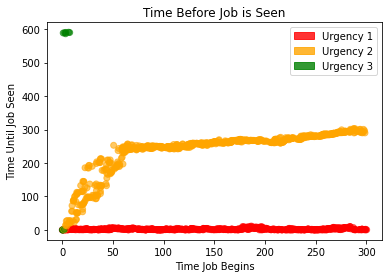

 
**********************************************************
 
Images arrive every 0.6000000000000001 minutes.
1470 medical images
There are 268 that were not completed in time
Simulation complete at 599.8040021847238 minutes


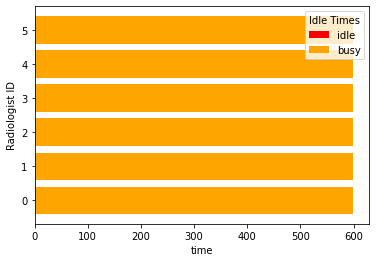

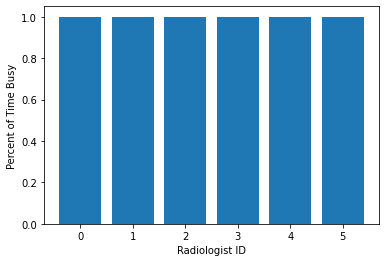

Radiologists were busy 0.999 of the time.


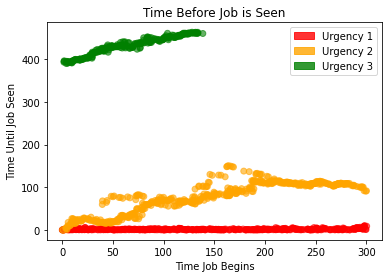

 
**********************************************************
 
Images arrive every 0.8000000000000002 minutes.
1121 medical images
There are 0 that were not completed in time
Simulation complete at 598.3725924391325 minutes


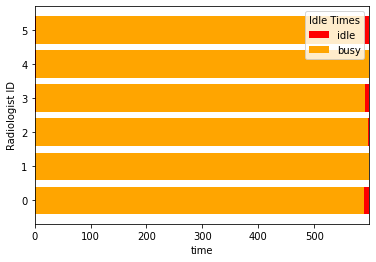

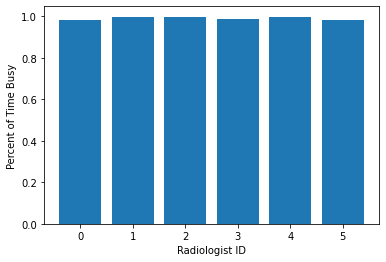

Radiologists were busy 0.989 of the time.


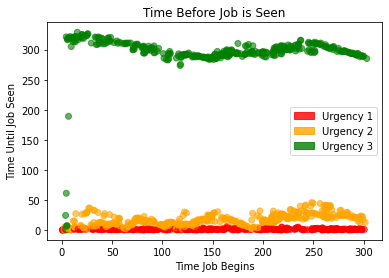

 
**********************************************************
 
Images arrive every 1.0000000000000002 minutes.
909 medical images
There are 0 that were not completed in time
Simulation complete at 531.5196362511978 minutes


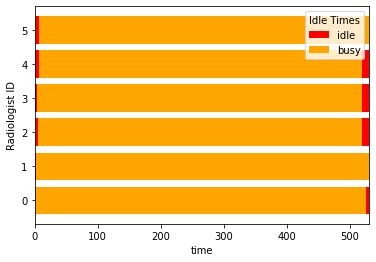

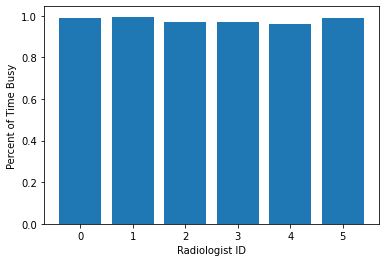

Radiologists were busy 0.98 of the time.


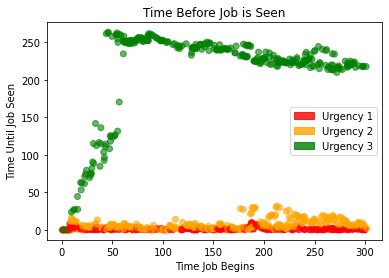

 
**********************************************************
 
Images arrive every 1.2000000000000002 minutes.
702 medical images
There are 0 that were not completed in time
Simulation complete at 419.7184517784922 minutes


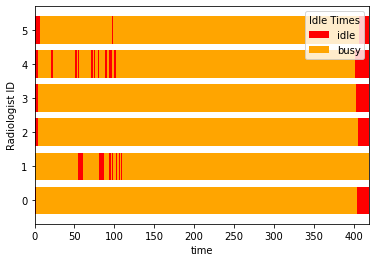

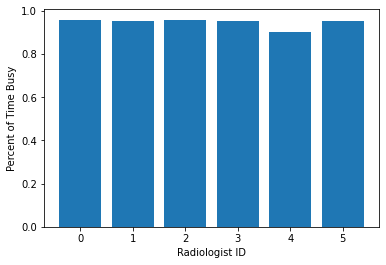

Radiologists were busy 0.945 of the time.


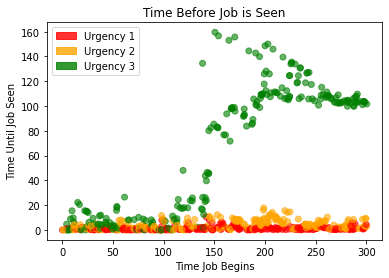

 
**********************************************************
 
Images arrive every 1.4000000000000004 minutes.
647 medical images
There are 0 that were not completed in time
Simulation complete at 390.53769621092374 minutes


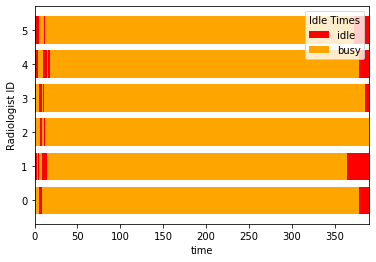

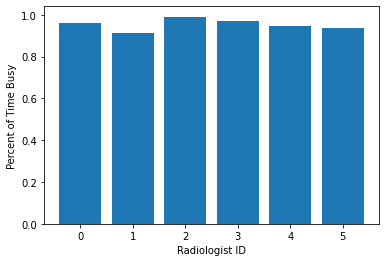

Radiologists were busy 0.951 of the time.


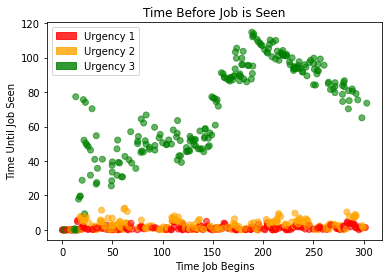

 
**********************************************************
 
Images arrive every 1.6000000000000005 minutes.
594 medical images
There are 0 that were not completed in time
Simulation complete at 339.6442332084102 minutes


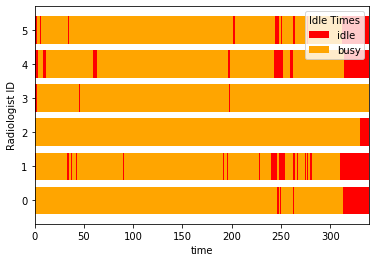

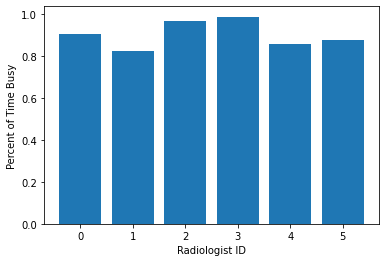

Radiologists were busy 0.904 of the time.


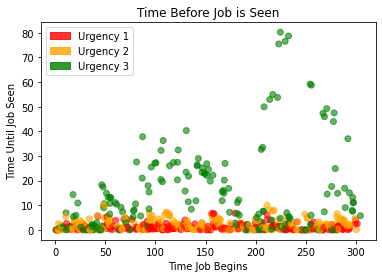

 
**********************************************************
 
Images arrive every 1.8000000000000003 minutes.
535 medical images
There are 0 that were not completed in time
Simulation complete at 307.2177292682349 minutes


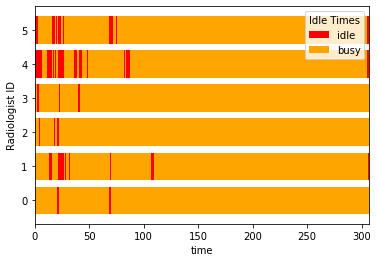

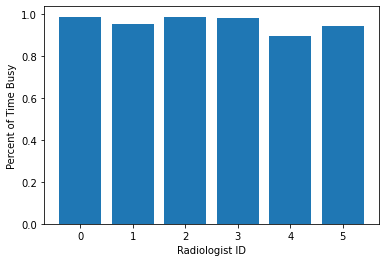

Radiologists were busy 0.957 of the time.


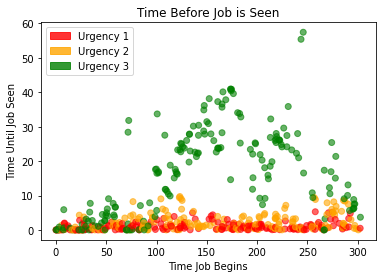

 
**********************************************************
 
Images arrive every 2.0000000000000004 minutes.
459 medical images
There are 0 that were not completed in time
Simulation complete at 322.0295257363233 minutes


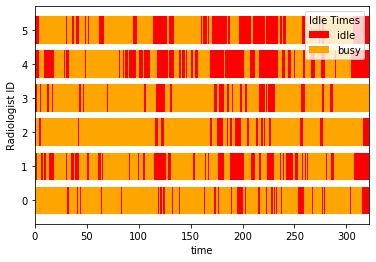

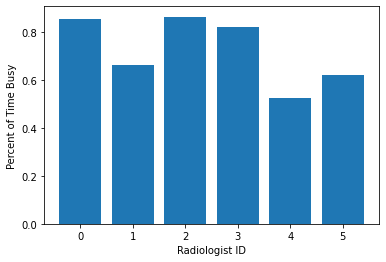

Radiologists were busy 0.724 of the time.


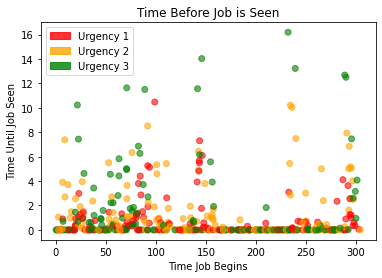

 
**********************************************************
 
Images arrive every 2.2000000000000006 minutes.
414 medical images
There are 0 that were not completed in time
Simulation complete at 314.79017618360666 minutes


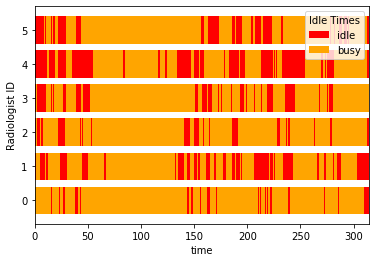

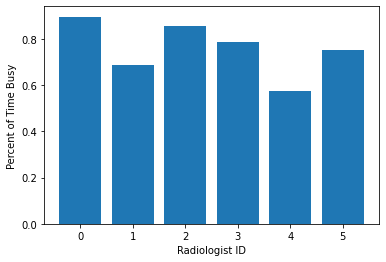

Radiologists were busy 0.76 of the time.


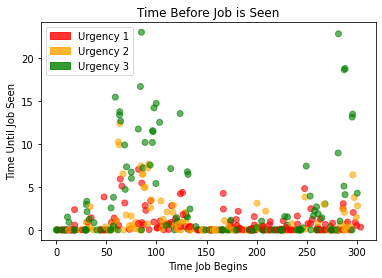

 
**********************************************************
 
Images arrive every 2.400000000000001 minutes.
407 medical images
There are 0 that were not completed in time
Simulation complete at 313.9386714275604 minutes


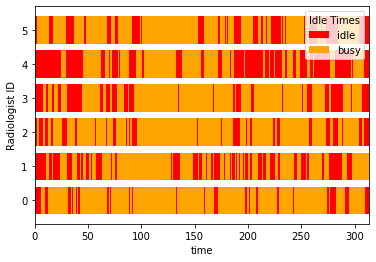

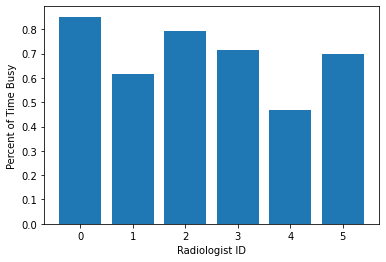

Radiologists were busy 0.691 of the time.


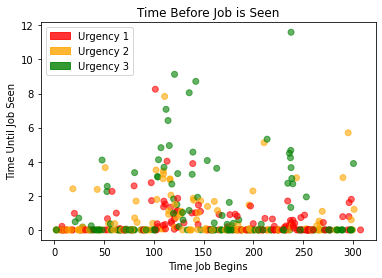

 
**********************************************************
 
Images arrive every 2.6000000000000005 minutes.
326 medical images
There are 0 that were not completed in time
Simulation complete at 315.33850066764455 minutes


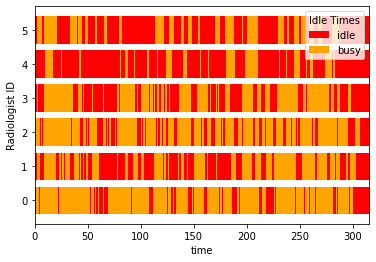

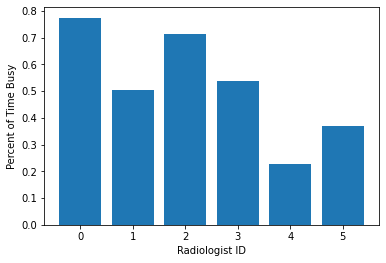

Radiologists were busy 0.521 of the time.


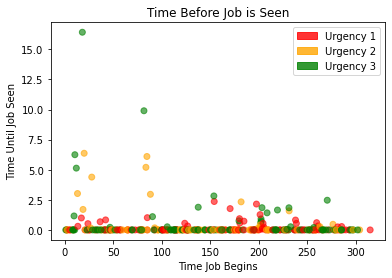

 
**********************************************************
 
Images arrive every 2.8000000000000007 minutes.
353 medical images
There are 0 that were not completed in time
Simulation complete at 310.7803215130586 minutes


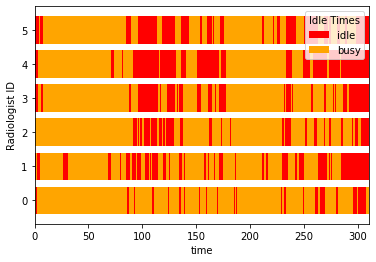

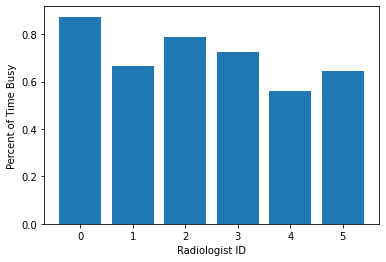

Radiologists were busy 0.709 of the time.


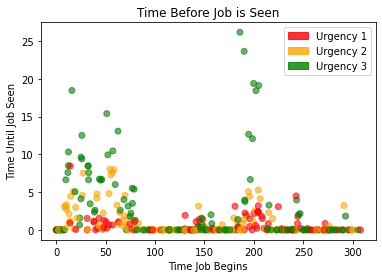

 
**********************************************************
 
Images arrive every 3.000000000000001 minutes.
279 medical images
There are 0 that were not completed in time
Simulation complete at 310.21991436210476 minutes


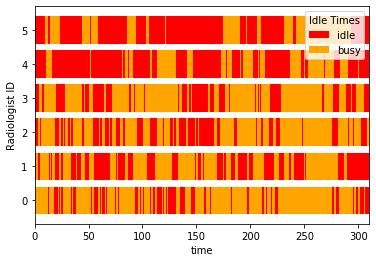

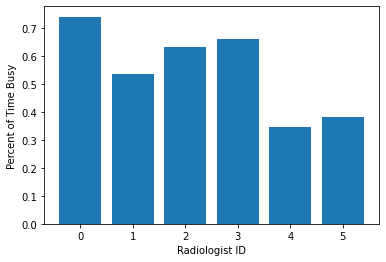

Radiologists were busy 0.55 of the time.


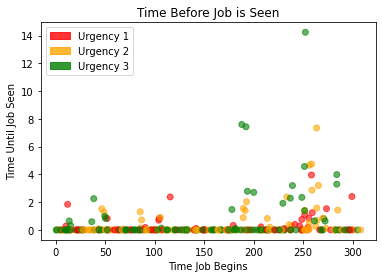

 
**********************************************************
 
Images arrive every 3.2000000000000006 minutes.
288 medical images
There are 0 that were not completed in time
Simulation complete at 319.5768709048031 minutes


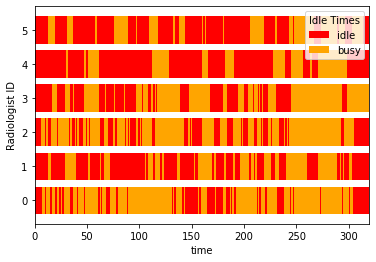

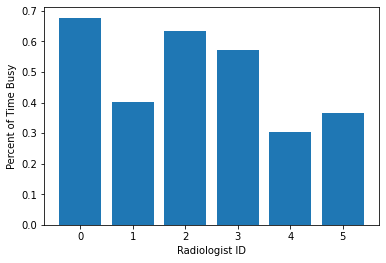

Radiologists were busy 0.492 of the time.


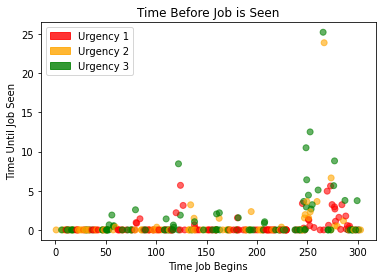

 
**********************************************************
 
Images arrive every 3.400000000000001 minutes.
251 medical images
There are 0 that were not completed in time
Simulation complete at 306.0522501102957 minutes


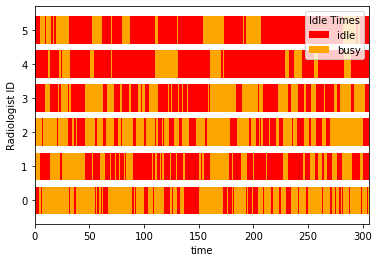

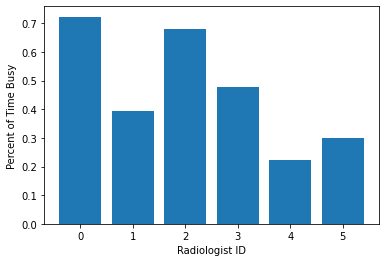

Radiologists were busy 0.466 of the time.


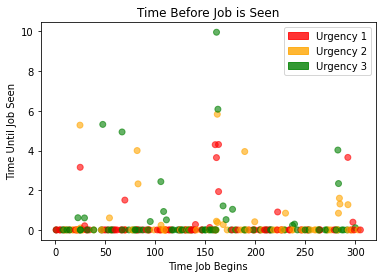

 
**********************************************************
 
Images arrive every 3.600000000000001 minutes.
258 medical images
There are 0 that were not completed in time
Simulation complete at 315.3951002186256 minutes


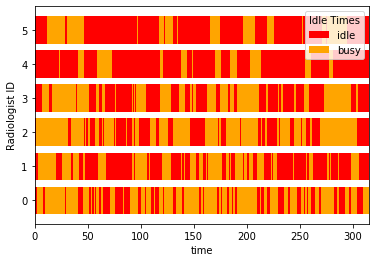

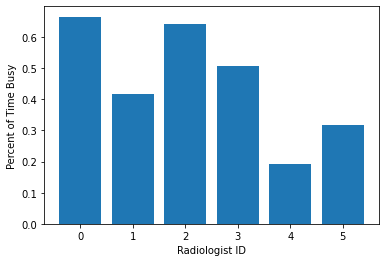

Radiologists were busy 0.457 of the time.


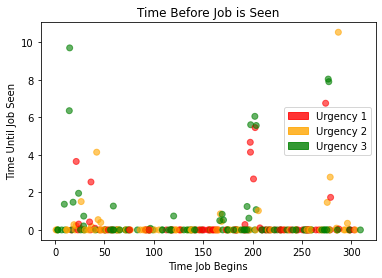

 
**********************************************************
 
Images arrive every 3.800000000000001 minutes.
237 medical images
There are 0 that were not completed in time
Simulation complete at 315.6463071361259 minutes


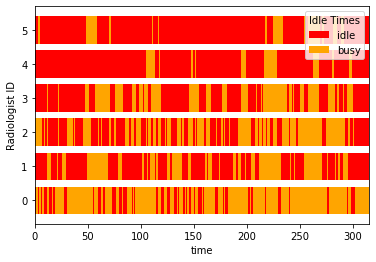

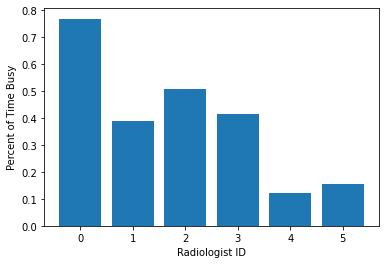

Radiologists were busy 0.393 of the time.


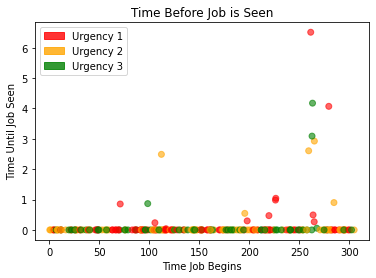

 
**********************************************************
 
Images arrive every 4.000000000000002 minutes.
231 medical images
There are 0 that were not completed in time
Simulation complete at 320.8145137283647 minutes


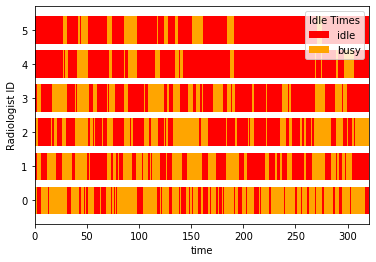

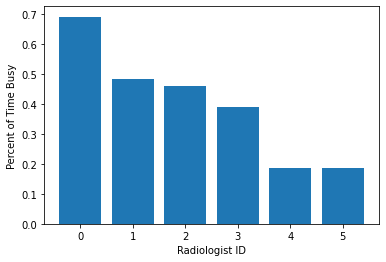

Radiologists were busy 0.399 of the time.


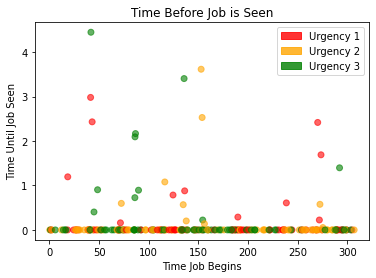

 
**********************************************************
 
Images arrive every 4.200000000000001 minutes.
223 medical images
There are 0 that were not completed in time
Simulation complete at 321.98924215942856 minutes


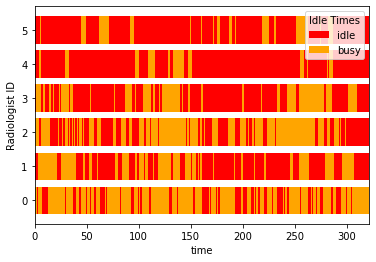

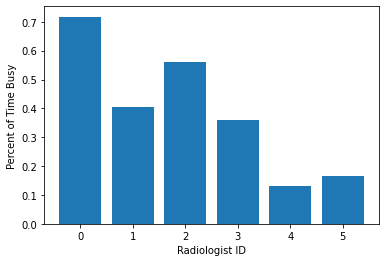

Radiologists were busy 0.39 of the time.


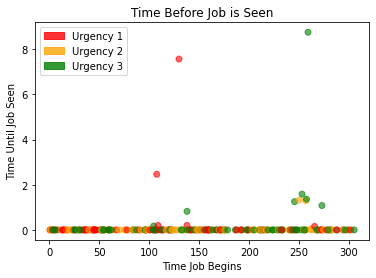

 
**********************************************************
 
Images arrive every 4.400000000000002 minutes.
230 medical images
There are 0 that were not completed in time
Simulation complete at 328.6671428840855 minutes


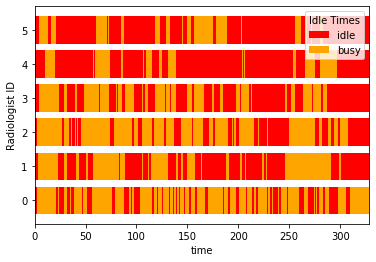

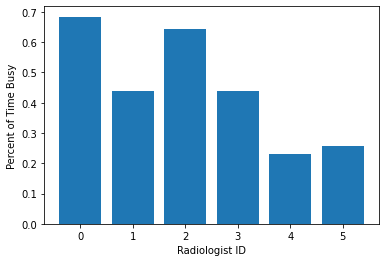

Radiologists were busy 0.449 of the time.


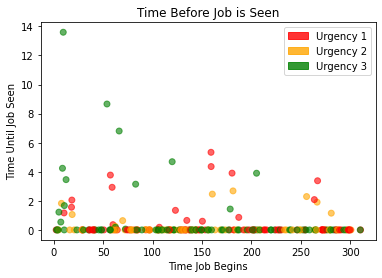

 
**********************************************************
 
Images arrive every 4.600000000000001 minutes.
203 medical images
There are 0 that were not completed in time
Simulation complete at 310.36675715253966 minutes


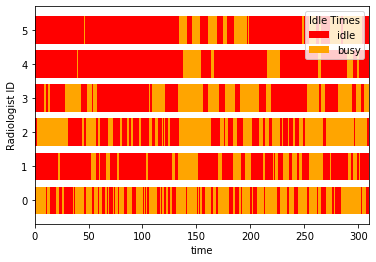

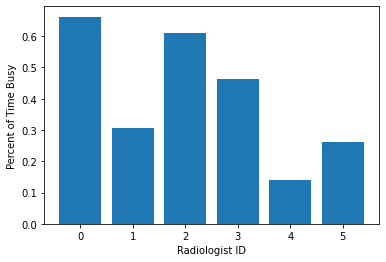

Radiologists were busy 0.407 of the time.


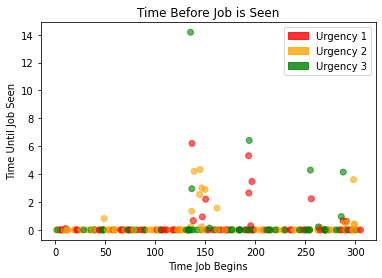

 
**********************************************************
 
Images arrive every 4.800000000000002 minutes.
197 medical images
There are 0 that were not completed in time
Simulation complete at 310.8546077288484 minutes


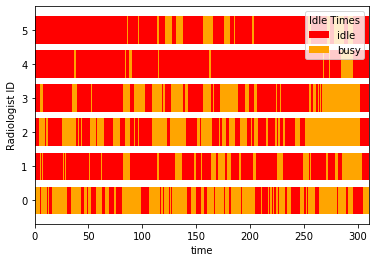

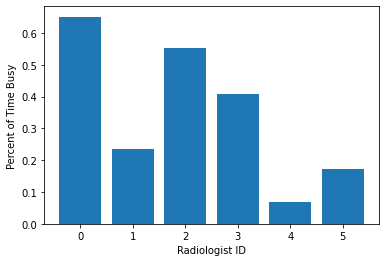

Radiologists were busy 0.348 of the time.


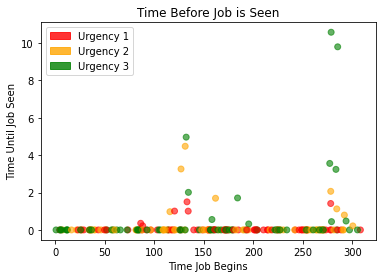

 
**********************************************************
 
Images arrive every 5.000000000000002 minutes.
178 medical images
There are 0 that were not completed in time
Simulation complete at 326.83441047855246 minutes


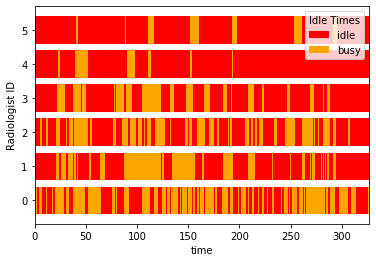

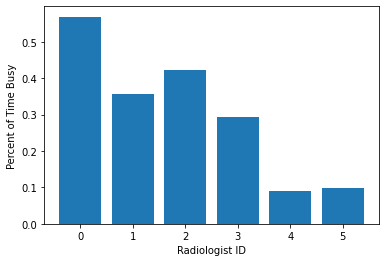

Radiologists were busy 0.305 of the time.


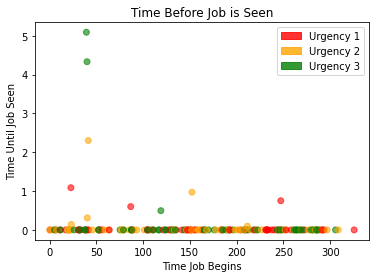

 
**********************************************************
 
Images arrive every 5.200000000000002 minutes.
188 medical images
There are 0 that were not completed in time
Simulation complete at 307.77893912699176 minutes


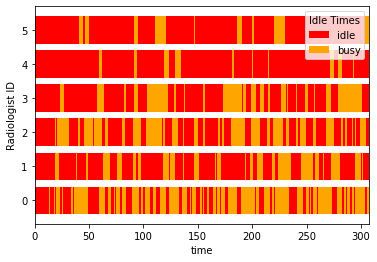

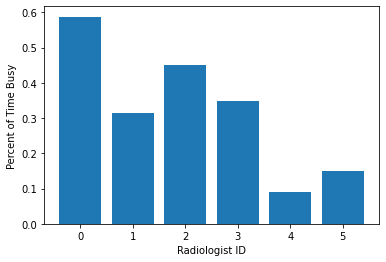

Radiologists were busy 0.323 of the time.


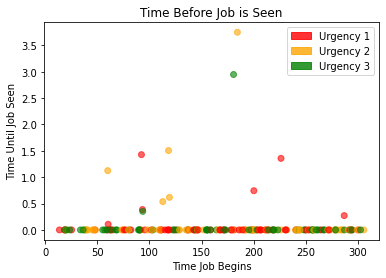

 
**********************************************************
 
Images arrive every 5.400000000000002 minutes.
174 medical images
There are 0 that were not completed in time
Simulation complete at 318.7118696158157 minutes


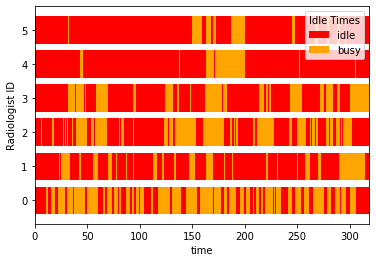

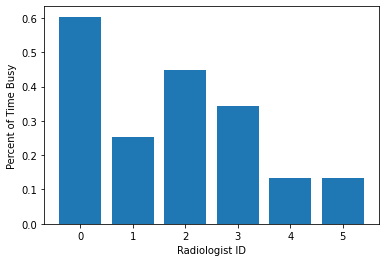

Radiologists were busy 0.319 of the time.


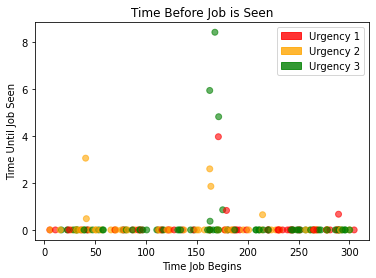

 
**********************************************************
 
Images arrive every 5.600000000000002 minutes.
145 medical images
There are 0 that were not completed in time
Simulation complete at 308.9508665587821 minutes


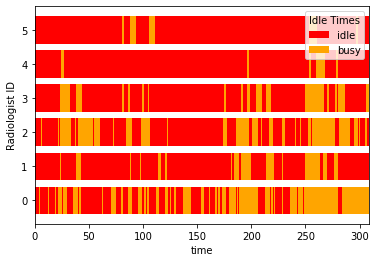

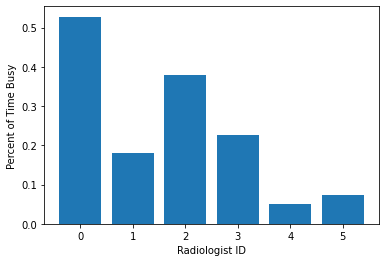

Radiologists were busy 0.24 of the time.


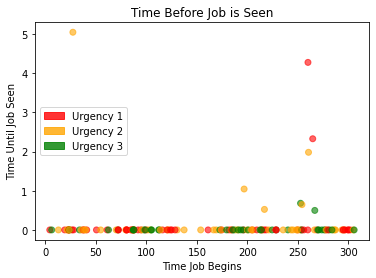

 
**********************************************************
 
Images arrive every 5.8000000000000025 minutes.
152 medical images
There are 0 that were not completed in time
Simulation complete at 335.2707597130989 minutes


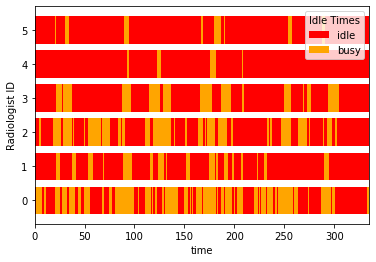

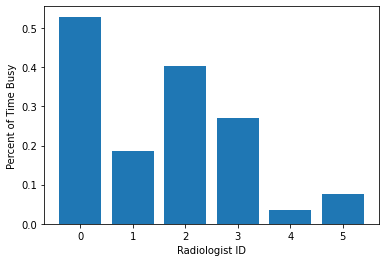

Radiologists were busy 0.25 of the time.


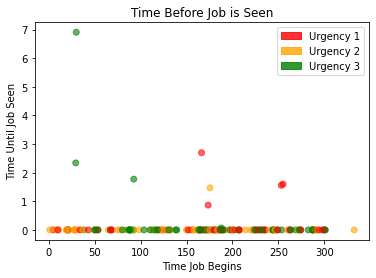

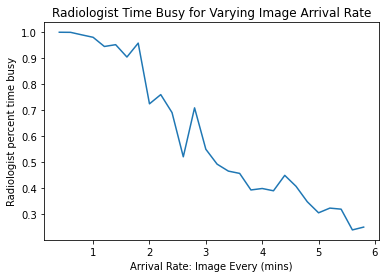

In [67]:
busy_times = {}
sims_dict = {}
create_constant_rads(6)
for arr_rate_var in np.arange(0.4, 6.0, 0.2):
    print(" ")
    print("**********************************************************")
    print(" ")
    print(f"Images arrive every {arr_rate_var} minutes.")
    #Define variables
    sim_time = 60*5
    rads_count = 6
    arr_rates = [arr_rate_var, arr_rate_var, arr_rate_var]
    urg_times = [2, 5, 10]
    #run sim
    s_temp = sim(sim_time, rads_count, arr_rates, urg_times, constant_rads=True, cutoff=True, verbose=False)
    
    busy_times[arr_rate_var] = idle_plots(s_temp.rads)
    wait_time_plot(s_temp.img_table)
    sims_dict[arr_rate_var] = s_temp
plt.plot(busy_times.keys(), busy_times.values(), label=f"{rads_count} radiologists")
plt.xlabel("Arrival Rate: Image Every (mins)")
plt.ylabel("Radiologist percent time busy")
plt.title("Radiologist Time Busy for Varying Image Arrival Rate")
plt.show()

Time plots for images arriving avg every 0.4 mins


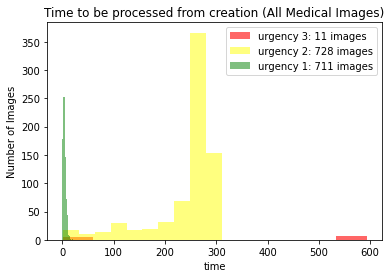

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 4.238386962745135
Urgency 2: 240.82422498726157
Urgency 3: 324.67097398651407


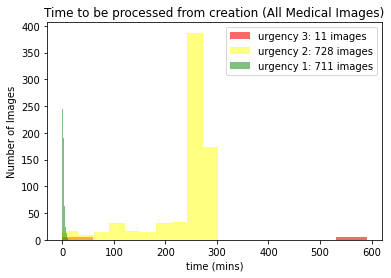

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.3339799134258903
Urgency 2: 237.8151496413206
Urgency 3: 321.5399349113776

_______________________________________________

Time plots for images arriving avg every 0.6 mins


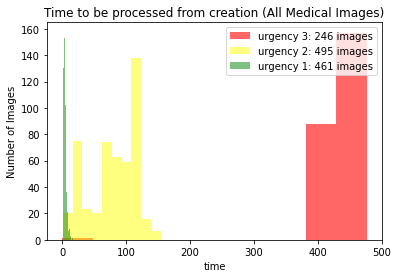

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 3.3537774993271707
Urgency 2: 79.19842448857207
Urgency 3: 433.7604377130544


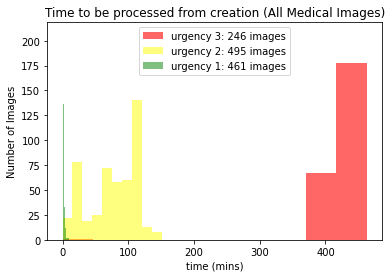

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.4678345084002877
Urgency 2: 76.13411562305993
Urgency 3: 428.8855074029669

_______________________________________________

Time plots for images arriving avg every 0.8 mins


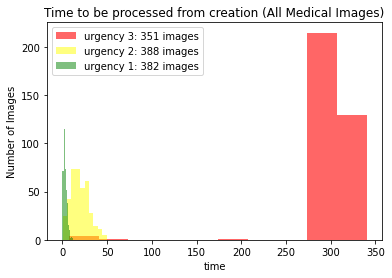

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 3.1021085005111266
Urgency 2: 19.687088730626538
Urgency 3: 300.6058077655069


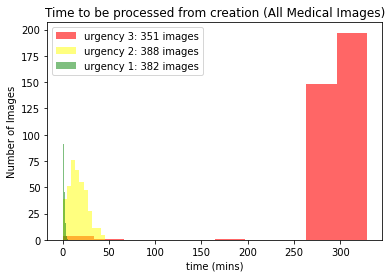

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.1392167012814831
Urgency 2: 16.705281126568924
Urgency 3: 295.92041302746605

_______________________________________________

Time plots for images arriving avg every 1.0 mins


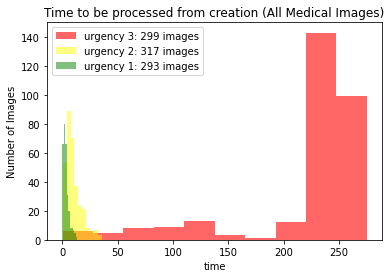

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 3.334986415673348
Urgency 2: 10.025710447232598
Urgency 3: 218.18064201669867


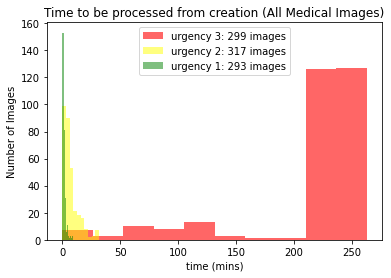

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.3154039930303587
Urgency 2: 6.940529204473168
Urgency 3: 212.9799116067699

_______________________________________________

Time plots for images arriving avg every 1.2 mins


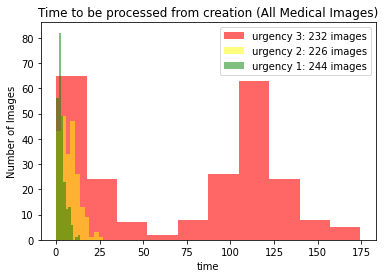

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 3.168984609634106
Urgency 2: 7.658008295062132
Urgency 3: 73.0079946571517


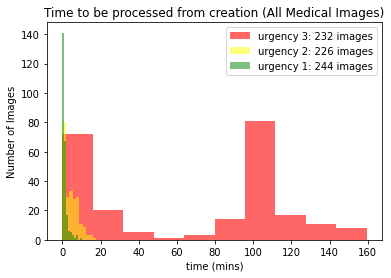

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.2813263730666042
Urgency 2: 4.4411785252776275
Urgency 3: 67.87427126884226

_______________________________________________

Time plots for images arriving avg every 1.4 mins


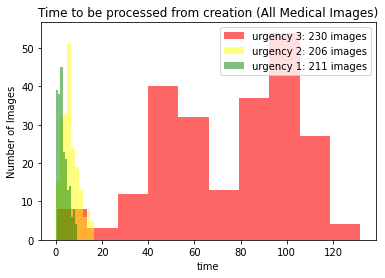

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 3.072252433256673
Urgency 2: 6.260904127060876
Urgency 3: 75.19416105408244


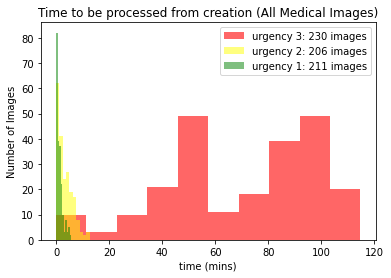

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.225565513839383
Urgency 2: 3.2935021747947784
Urgency 3: 69.85245273370899

_______________________________________________

Time plots for images arriving avg every 1.6 mins


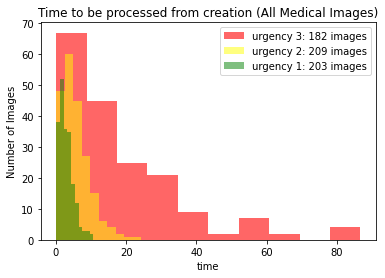

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.9688800334739804
Urgency 2: 5.580505379989666
Urgency 3: 18.382700638418225


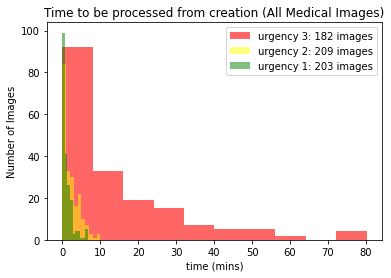

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.1922037805982653
Urgency 2: 2.2363779535681787
Urgency 3: 14.082609783736313

_______________________________________________

Time plots for images arriving avg every 1.8 mins


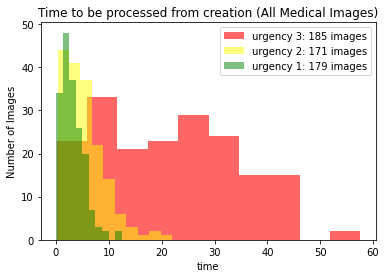

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 3.120007739297988
Urgency 2: 5.347825770880759
Urgency 3: 21.51233472232296


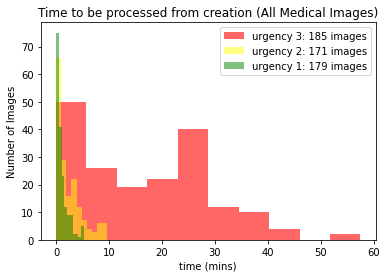

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.038613264826782
Urgency 2: 2.4222581149592037
Urgency 3: 16.690863228763227

_______________________________________________

Time plots for images arriving avg every 2.0 mins


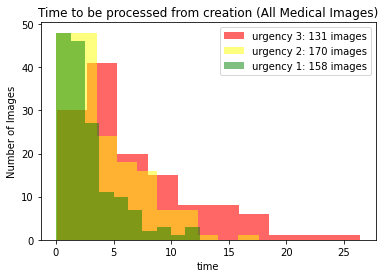

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.813508781087712
Urgency 2: 4.06150093614447
Urgency 3: 6.477695104214863


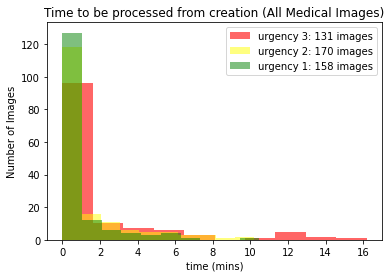

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.8010606612656053
Urgency 2: 1.276617420797665
Urgency 3: 1.8384317308248437

_______________________________________________

Time plots for images arriving avg every 2.2 mins


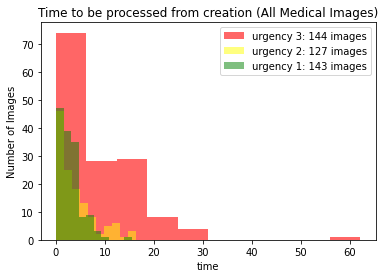

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.9052479821503416
Urgency 2: 4.05985826231436
Urgency 3: 8.57695176505686


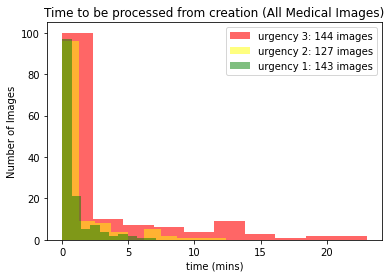

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.8123961770526218
Urgency 2: 1.2756013620887308
Urgency 3: 3.1481176661833907

_______________________________________________

Time plots for images arriving avg every 2.4 mins


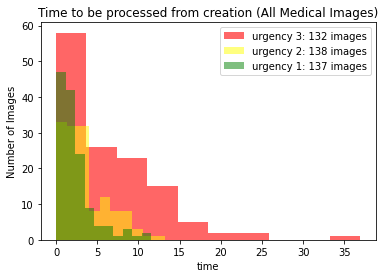

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.241881832849776
Urgency 2: 3.46448175385181
Urgency 3: 6.301254459865904


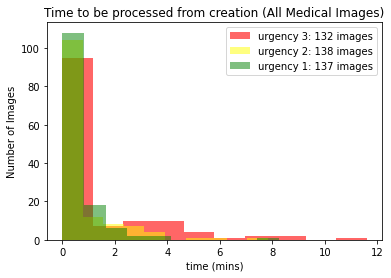

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.48244447719551814
Urgency 2: 0.6375898317634836
Urgency 3: 1.2286699322425318

_______________________________________________

Time plots for images arriving avg every 2.6 mins


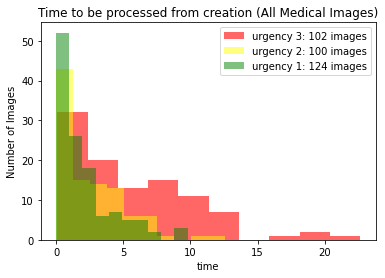

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.0837912197318027
Urgency 2: 2.5861202728968067
Urgency 3: 5.692054127211826


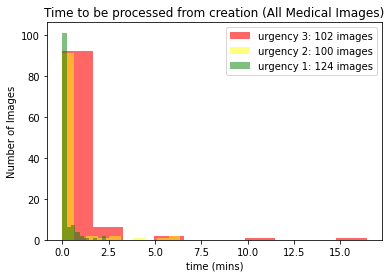

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.15339796256010393
Urgency 2: 0.3567116397958654
Urgency 3: 0.5677261461601573

_______________________________________________

Time plots for images arriving avg every 2.8 mins


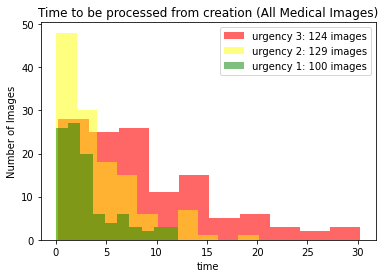

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 3.1908218875308756
Urgency 2: 4.2618106586970255
Urgency 3: 8.679741222588596


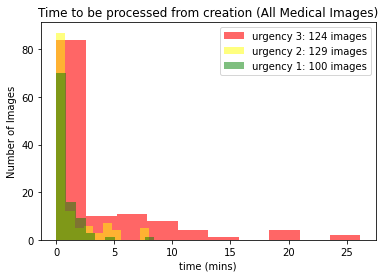

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.6877682373341207
Urgency 2: 1.1532260739332585
Urgency 3: 3.2752153080598605

_______________________________________________

Time plots for images arriving avg every 3.0 mins


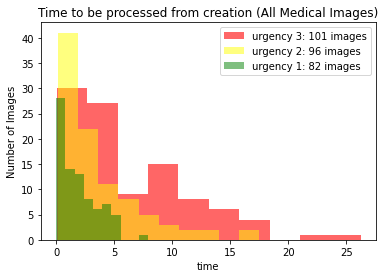

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.9214769176814055
Urgency 2: 3.604291919314146
Urgency 3: 6.460215186983288


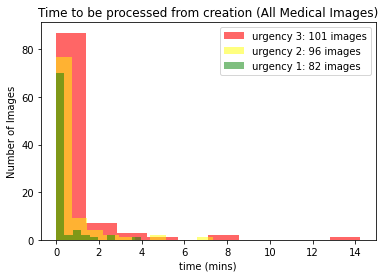

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.2497425882501618
Urgency 2: 0.47441367731431683
Urgency 3: 0.6645075940410154

_______________________________________________

Time plots for images arriving avg every 3.2 mins


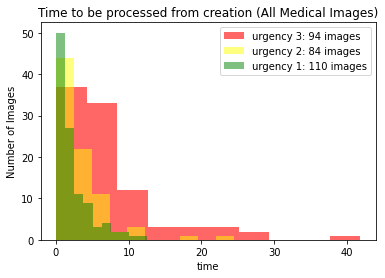

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.317102232611169
Urgency 2: 3.2908004584413235
Urgency 3: 6.899358878698513


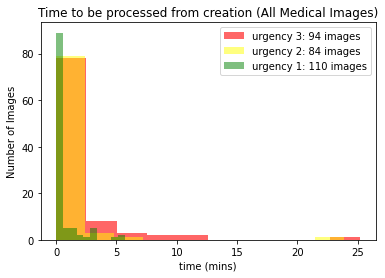

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.47943763825752717
Urgency 2: 0.6780638956405711
Urgency 3: 1.3423465833719554

_______________________________________________

Time plots for images arriving avg every 3.4 mins


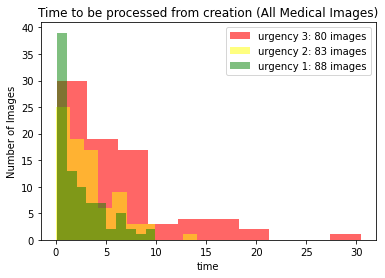

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.329913700287315
Urgency 2: 3.2074889880516064
Urgency 3: 5.991249114796054


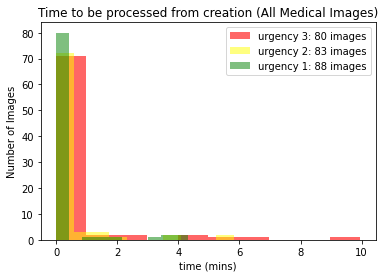

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.27707622784159336
Urgency 2: 0.35747325727008883
Urgency 3: 0.5195702263953319

_______________________________________________

Time plots for images arriving avg every 3.6 mins


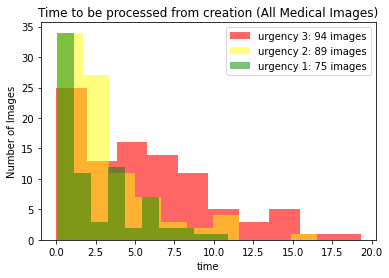

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.5150298831177835
Urgency 2: 3.163877687087916
Urgency 3: 5.467495654898762


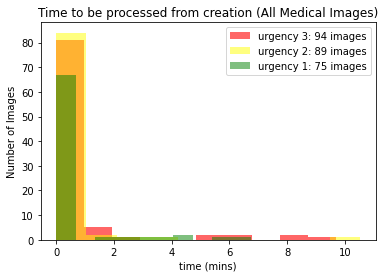

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.43995930899319013
Urgency 2: 0.2795591341213088
Urgency 3: 0.6581608981365401

_______________________________________________

Time plots for images arriving avg every 3.8 mins


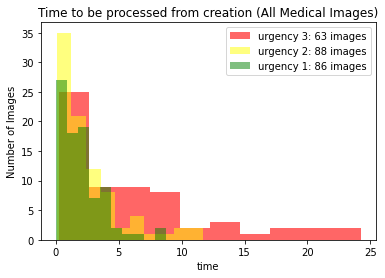

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.970002516242864
Urgency 2: 2.517437721132146
Urgency 3: 6.135545094809445


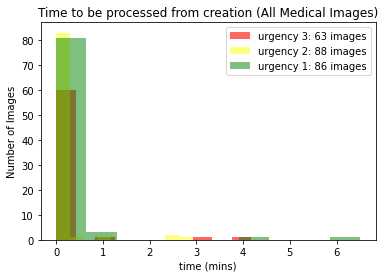

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.17749583767739674
Urgency 2: 0.10757915490571547
Urgency 3: 0.1299690766321919

_______________________________________________

Time plots for images arriving avg every 4.0 mins


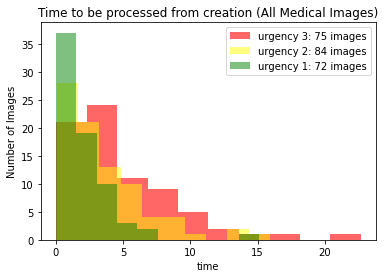

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.1175958036385083
Urgency 2: 3.5306599393266733
Urgency 3: 4.775981032532396


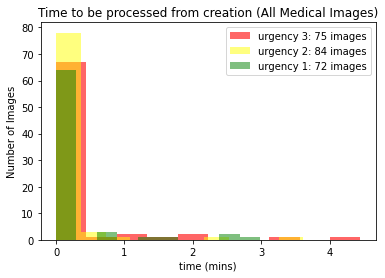

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.1897114959605951
Urgency 2: 0.11139226266098456
Urgency 3: 0.22214099702571738

_______________________________________________

Time plots for images arriving avg every 4.2 mins


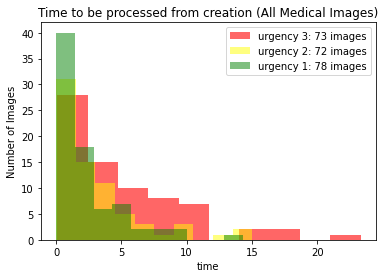

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.3159034662554276
Urgency 2: 3.1006642504011346
Urgency 3: 5.175236242140846


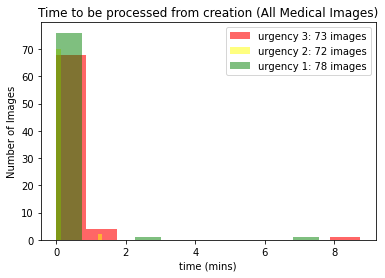

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.13556597038168733
Urgency 2: 0.03709296948507972
Urgency 3: 0.20569102343427884

_______________________________________________

Time plots for images arriving avg every 4.4 mins


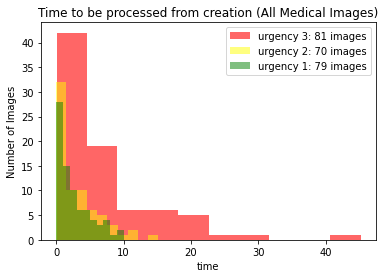

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.5681910453581573
Urgency 2: 3.05186914316098
Urgency 3: 7.060612543936534


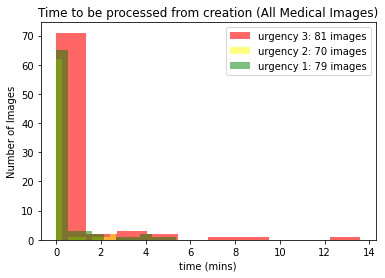

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.4376853994446075
Urgency 2: 0.20440174947425838
Urgency 3: 0.6619692205083396

_______________________________________________

Time plots for images arriving avg every 4.6 mins


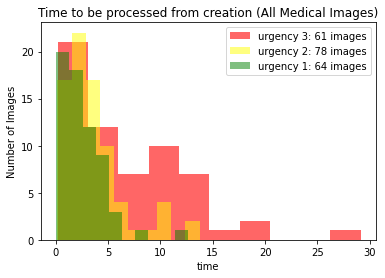

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.4699201343491732
Urgency 2: 3.50181405725561
Urgency 3: 6.763794195262839


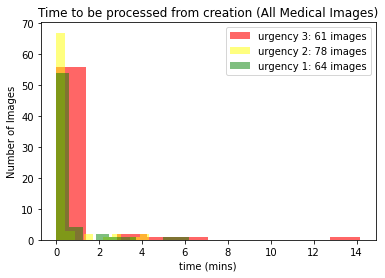

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.39621071703212074
Urgency 2: 0.34364291246414014
Urgency 3: 0.5458609130669915

_______________________________________________

Time plots for images arriving avg every 4.8 mins


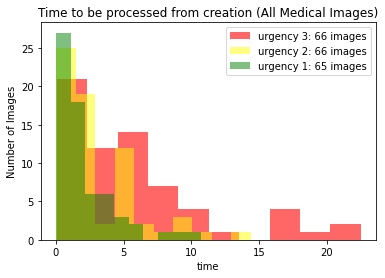

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.0910431385897894
Urgency 2: 2.9132146188363492
Urgency 3: 5.730384445453404


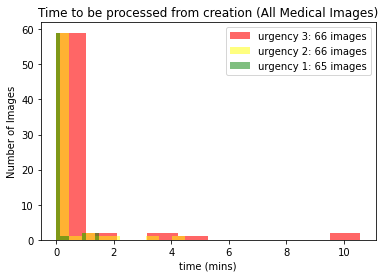

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.08483318773769388
Urgency 2: 0.22109474022645384
Urgency 3: 0.56988189625915

_______________________________________________

Time plots for images arriving avg every 5.0 mins


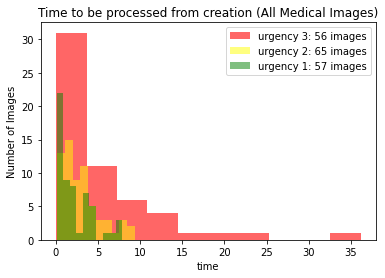

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.1038513717790805
Urgency 2: 3.039803133357735
Urgency 3: 5.310720563175073


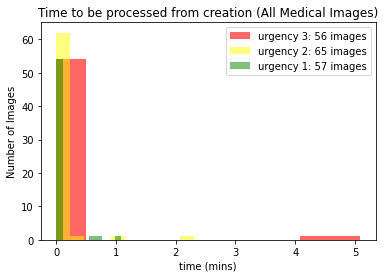

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.042783860569794496
Urgency 2: 0.05874650099788562
Urgency 3: 0.17707620826504286

_______________________________________________

Time plots for images arriving avg every 5.2 mins


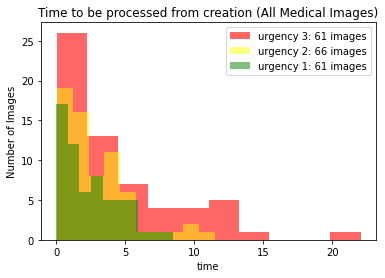

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.4464026205296547
Urgency 2: 2.874849857118428
Urgency 3: 4.481941055199312


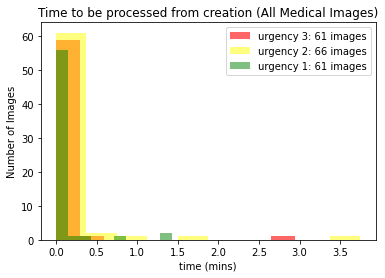

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.07036295547994086
Urgency 2: 0.11414086484990535
Urgency 3: 0.05408502312955722

_______________________________________________

Time plots for images arriving avg every 5.4 mins


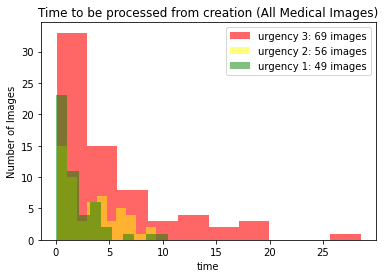

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.027987136456037
Urgency 2: 3.1639556970709846
Urgency 3: 5.343791473863327


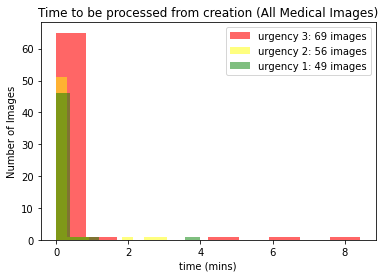

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.11176377195674286
Urgency 2: 0.15453846601467675
Urgency 3: 0.29632996567523107

_______________________________________________

Time plots for images arriving avg every 5.6 mins


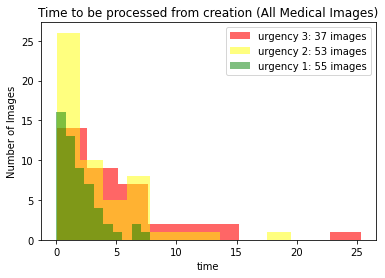

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.8771781129608538
Urgency 2: 3.37990601436131
Urgency 3: 4.83185498726776


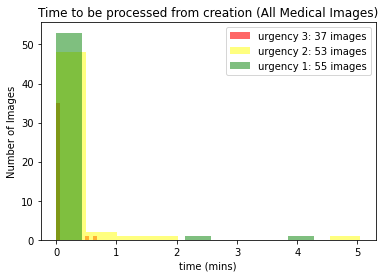

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.12012358108108649
Urgency 2: 0.17443693968999804
Urgency 3: 0.031848530203563076

_______________________________________________

Time plots for images arriving avg every 5.8 mins


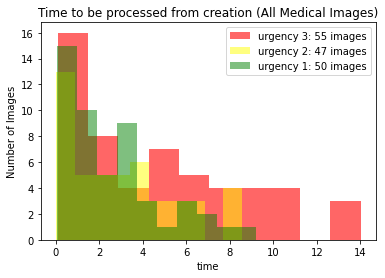

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.5224960861156682
Urgency 2: 3.0114835752546933
Urgency 3: 4.642972530578423


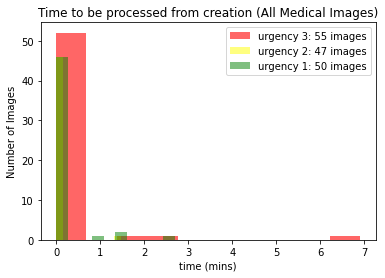

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.13451272613979712
Urgency 2: 0.03133235691964721
Urgency 3: 0.20172472723080623

_______________________________________________



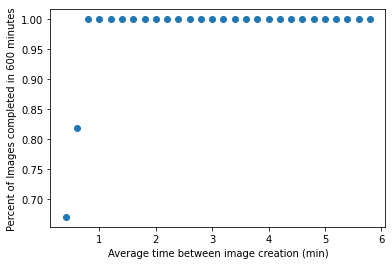

In [68]:
for arr_val, s in sims_dict.items():
    print(f"Time plots for images arriving avg every {round(arr_val,2)} mins")
    total_time_hist(s)
    wait_time_hist(s)
    print("")
    print("_______________________________________________")
    print("")
    
completion_plot(sims_dict)

In [76]:
ex_img_table = sims_dict[list(sims_dict.keys())[10]].img_table
ex_img_table#[ex_img_table.create_time >=5].iloc[0]

img_id  urgency  create_time   seen_time    finished  img_wait_time  \
0       0.0      3.0     1.950267    1.950267    2.513628       0.000000   
1       1.0      2.0     2.101239    2.101239    4.433997       0.000000   
2       3.0      2.0     4.915821    4.915821    5.522861       0.000000   
3       4.0      2.0     6.069814    6.069814    6.982890       0.000000   
4       6.0      3.0     7.736205    7.736205    7.989945       0.000000   
..      ...      ...          ...         ...         ...            ...   
402   405.0      2.0   301.015652  302.220745  306.804245       1.205093   
403   402.0      3.0   298.879085  298.879085  308.545217       0.000000   
404   406.0      1.0   307.491680  307.491680  308.601866       0.000000   
405   404.0      3.0   300.410202  304.304470  310.240374       3.894268   
406   397.0      3.0   297.467604  297.467604  313.938671       0.000000   

     time_w_rad  total_time  
0      0.563361    0.563361  
1      2.332759    2.332759  
2      0.607040    0.607040  
3      0.913075    0.913075  
4      0.253739    0.253739  
..          ...         ...  
402    4.583500    5.788593  
403    9.666132    9.666132  
404    1.110186    1.110186  
405    5.935904    9.830172  
406   16.471068   16.471068  

[407 rows x 8 columns]

Radiologist 0 was busy 0.999 of the time.
Radiologist 1 was busy 1.0 of the time.
Radiologist 2 was busy 0.998 of the time.
Radiologist 3 was busy 0.997 of the time.


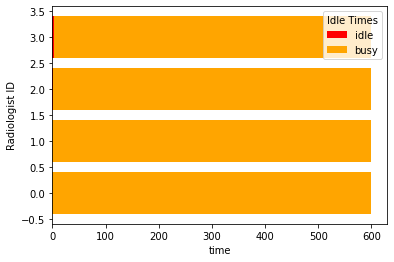

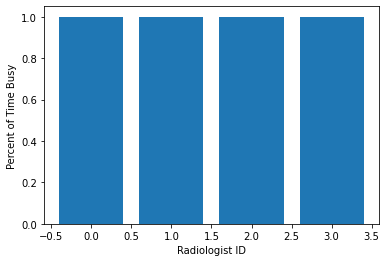

Radiologists were busy 0.999 of the time.


0.9986767984055939

In [8]:
idle_plots(s1.rads)

(array([19., 17., 52., 26., 32., 26., 56., 51., 29., 10.]),
 array([  1.19621547,  16.92664335,  32.65707122,  48.3874991 ,
         64.11792697,  79.84835485,  95.57878273, 111.3092106 ,
        127.03963848, 142.77006635, 158.50049423]),
 <BarContainer object of 10 artists>)

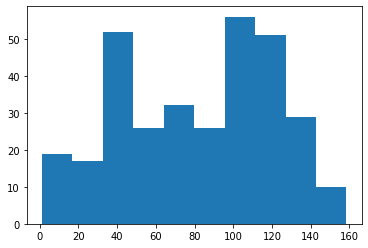

In [260]:
plt.hist(s1.img_table[s1.img_table.urgency==2].total_time)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  80., 223.]),
 array([ 12.60202598,  58.10679206, 103.61155815, 149.11632423,
        194.62109031, 240.12585639, 285.63062247, 331.13538855,
        376.64015463, 422.14492071, 467.6496868 ]),
 <BarContainer object of 10 artists>)

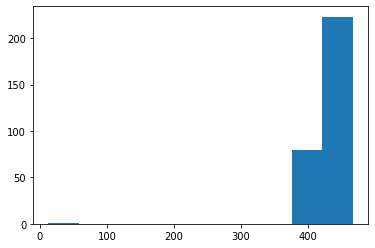

In [261]:
plt.hist(s1.img_table[s1.img_table.urgency==3].total_time)

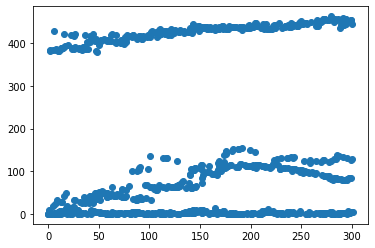

In [262]:
wait_time_plot(s1.img_table)

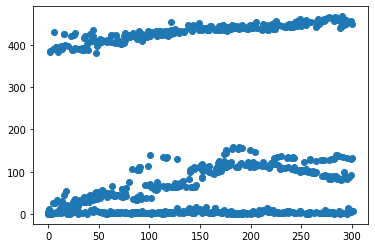

In [263]:
total_time_plot(s1.img_table)

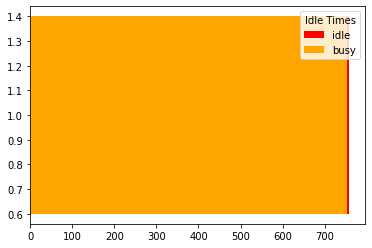

In [264]:
rad_idle_plot(s1.rads[1])

Radiologist 0 was busy 1.0 of the time.
Radiologist 1 was busy 1.0 of the time.
Radiologist 2 was busy 0.999 of the time.
Radiologist 3 was busy 0.999 of the time.


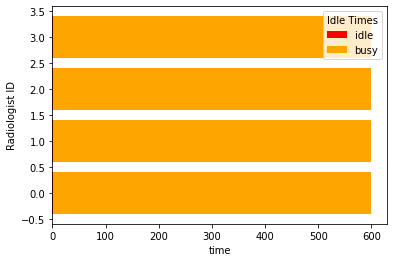

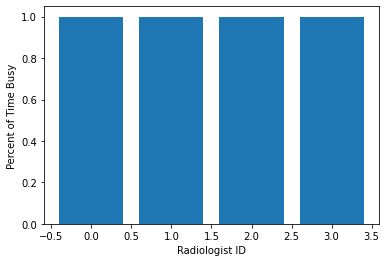

Radiologists were busy 0.999 of the time.


0.9993081471706555

In [42]:
idle_plots(s1.rads)

2319 medical images
There are 901 that were not completed in time
Simulation complete at 600 minutes
Radiologist 0 was busy 1.0 of the time.
Radiologist 1 was busy 1.0 of the time.
Radiologist 2 was busy 1.0 of the time.
Radiologist 3 was busy 0.999 of the time.
Radiologist 4 was busy 0.999 of the time.
Radiologist 5 was busy 0.999 of the time.


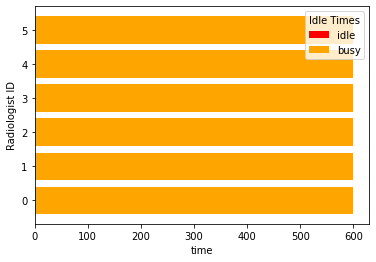

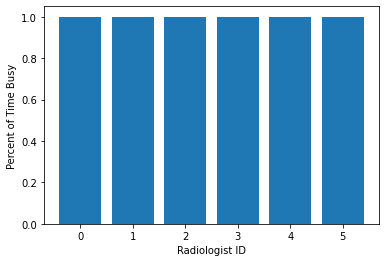

Radiologists were busy 0.999 of the time.
1405 medical images
There are 183 that were not completed in time
Simulation complete at 600 minutes
Radiologist 0 was busy 0.998 of the time.
Radiologist 1 was busy 0.999 of the time.
Radiologist 2 was busy 0.998 of the time.
Radiologist 3 was busy 0.997 of the time.
Radiologist 4 was busy 1.0 of the time.
Radiologist 5 was busy 0.999 of the time.


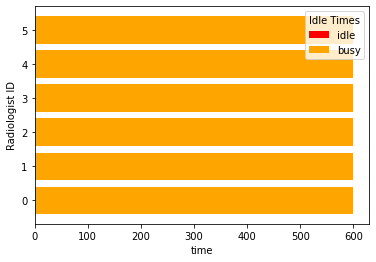

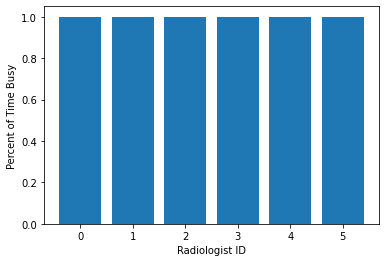

Radiologists were busy 0.998 of the time.
1145 medical images
There are 5 that were not completed in time
Simulation complete at 600 minutes
Radiologist 0 was busy 0.998 of the time.
Radiologist 1 was busy 0.997 of the time.
Radiologist 2 was busy 0.997 of the time.
Radiologist 3 was busy 0.996 of the time.
Radiologist 4 was busy 0.989 of the time.
Radiologist 5 was busy 0.995 of the time.


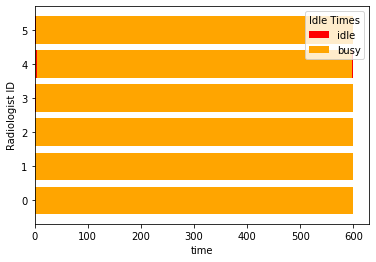

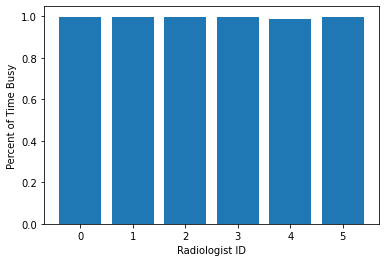

Radiologists were busy 0.995 of the time.
864 medical images
There are 0 that were not completed in time
Simulation complete at 600 minutes
Radiologist 0 was busy 0.835 of the time.
Radiologist 1 was busy 0.839 of the time.
Radiologist 2 was busy 0.853 of the time.
Radiologist 3 was busy 0.836 of the time.
Radiologist 4 was busy 0.979 of the time.
Radiologist 5 was busy 0.859 of the time.


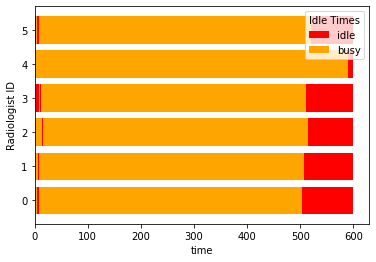

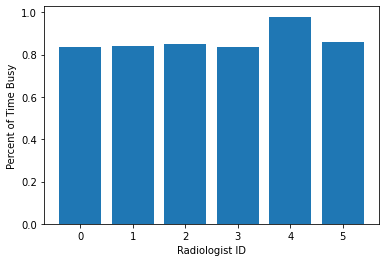

Radiologists were busy 0.867 of the time.
730 medical images
There are 0 that were not completed in time
Simulation complete at 600 minutes
Radiologist 0 was busy 0.86 of the time.
Radiologist 1 was busy 0.61 of the time.
Radiologist 2 was busy 0.578 of the time.
Radiologist 3 was busy 0.583 of the time.
Radiologist 4 was busy 0.583 of the time.
Radiologist 5 was busy 0.598 of the time.


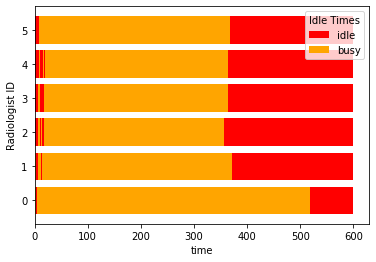

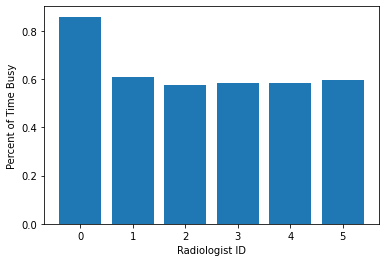

Radiologists were busy 0.635 of the time.
639 medical images
There are 0 that were not completed in time
Simulation complete at 600 minutes
Radiologist 0 was busy 0.647 of the time.
Radiologist 1 was busy 0.533 of the time.
Radiologist 2 was busy 0.642 of the time.
Radiologist 3 was busy 0.64 of the time.
Radiologist 4 was busy 0.472 of the time.
Radiologist 5 was busy 0.485 of the time.


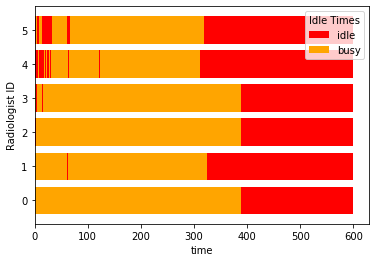

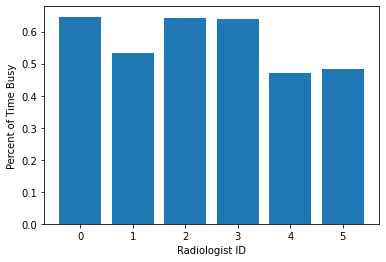

Radiologists were busy 0.57 of the time.
593 medical images
There are 0 that were not completed in time
Simulation complete at 600 minutes
Radiologist 0 was busy 0.545 of the time.
Radiologist 1 was busy 0.533 of the time.
Radiologist 2 was busy 0.537 of the time.
Radiologist 3 was busy 0.529 of the time.
Radiologist 4 was busy 0.541 of the time.
Radiologist 5 was busy 0.527 of the time.


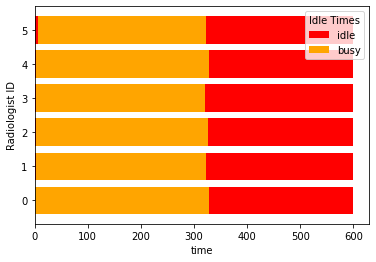

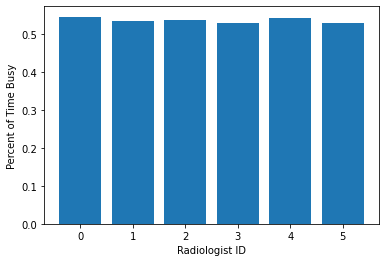

Radiologists were busy 0.536 of the time.
513 medical images
There are 0 that were not completed in time
Simulation complete at 600 minutes
Radiologist 0 was busy 0.499 of the time.
Radiologist 1 was busy 0.53 of the time.
Radiologist 2 was busy 0.446 of the time.
Radiologist 3 was busy 0.54 of the time.
Radiologist 4 was busy 0.48 of the time.
Radiologist 5 was busy 0.422 of the time.


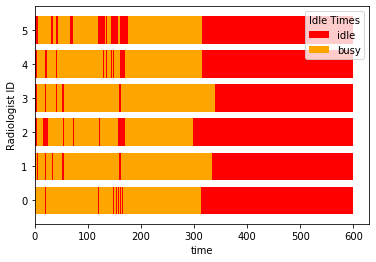

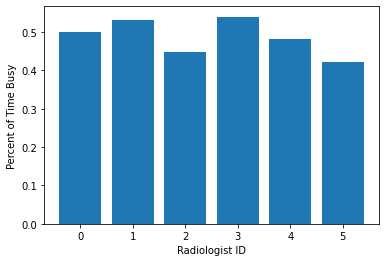

Radiologists were busy 0.486 of the time.
474 medical images
There are 0 that were not completed in time
Simulation complete at 600 minutes
Radiologist 0 was busy 0.459 of the time.
Radiologist 1 was busy 0.469 of the time.
Radiologist 2 was busy 0.423 of the time.
Radiologist 3 was busy 0.445 of the time.
Radiologist 4 was busy 0.403 of the time.
Radiologist 5 was busy 0.411 of the time.


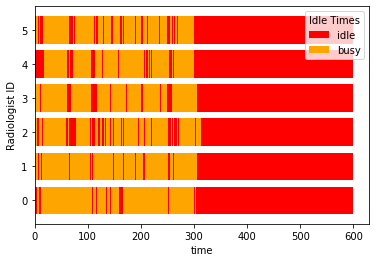

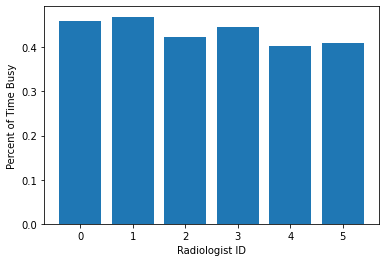

Radiologists were busy 0.435 of the time.
363 medical images
There are 0 that were not completed in time
Simulation complete at 600 minutes
Radiologist 0 was busy 0.41 of the time.
Radiologist 1 was busy 0.294 of the time.
Radiologist 2 was busy 0.329 of the time.
Radiologist 3 was busy 0.306 of the time.
Radiologist 4 was busy 0.225 of the time.
Radiologist 5 was busy 0.141 of the time.


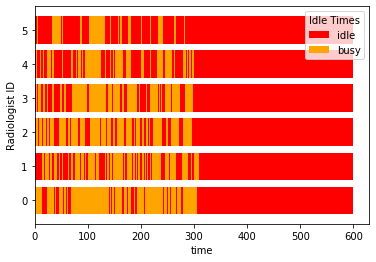

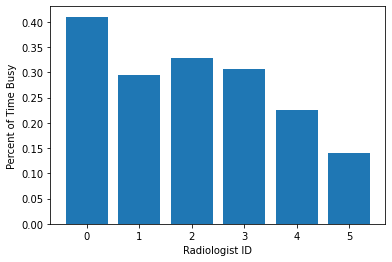

Radiologists were busy 0.284 of the time.
410 medical images
There are 0 that were not completed in time
Simulation complete at 600 minutes
Radiologist 0 was busy 0.442 of the time.
Radiologist 1 was busy 0.399 of the time.
Radiologist 2 was busy 0.401 of the time.
Radiologist 3 was busy 0.288 of the time.
Radiologist 4 was busy 0.374 of the time.
Radiologist 5 was busy 0.31 of the time.


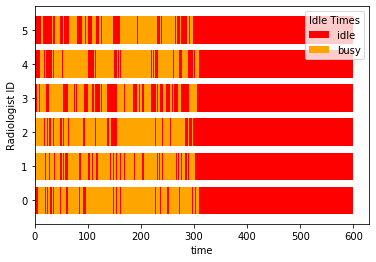

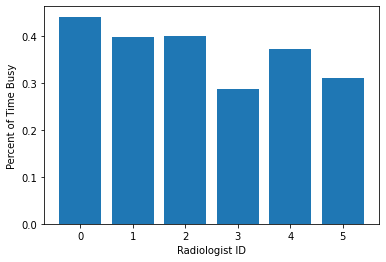

Radiologists were busy 0.369 of the time.
360 medical images
There are 0 that were not completed in time
Simulation complete at 600 minutes
Radiologist 0 was busy 0.405 of the time.
Radiologist 1 was busy 0.451 of the time.
Radiologist 2 was busy 0.426 of the time.
Radiologist 3 was busy 0.412 of the time.
Radiologist 4 was busy 0.284 of the time.
Radiologist 5 was busy 0.254 of the time.


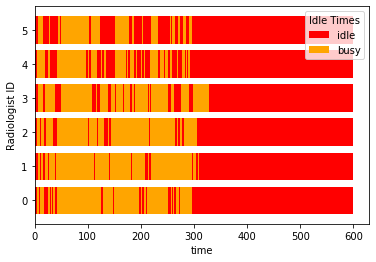

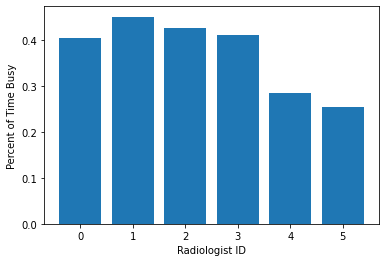

Radiologists were busy 0.372 of the time.
343 medical images
There are 0 that were not completed in time
Simulation complete at 600 minutes
Radiologist 0 was busy 0.439 of the time.
Radiologist 1 was busy 0.265 of the time.
Radiologist 2 was busy 0.349 of the time.
Radiologist 3 was busy 0.381 of the time.
Radiologist 4 was busy 0.349 of the time.
Radiologist 5 was busy 0.206 of the time.


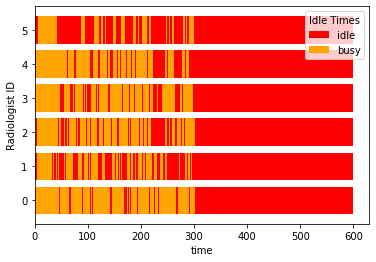

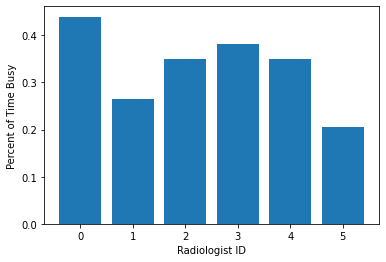

Radiologists were busy 0.332 of the time.
301 medical images
There are 0 that were not completed in time
Simulation complete at 600 minutes
Radiologist 0 was busy 0.313 of the time.
Radiologist 1 was busy 0.319 of the time.
Radiologist 2 was busy 0.308 of the time.
Radiologist 3 was busy 0.211 of the time.
Radiologist 4 was busy 0.095 of the time.
Radiologist 5 was busy 0.263 of the time.


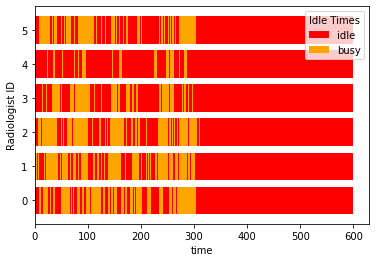

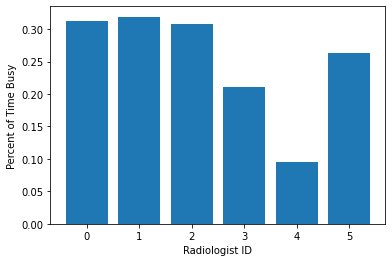

Radiologists were busy 0.252 of the time.
281 medical images
There are 0 that were not completed in time
Simulation complete at 600 minutes
Radiologist 0 was busy 0.263 of the time.
Radiologist 1 was busy 0.376 of the time.
Radiologist 2 was busy 0.138 of the time.
Radiologist 3 was busy 0.282 of the time.
Radiologist 4 was busy 0.278 of the time.
Radiologist 5 was busy 0.2 of the time.


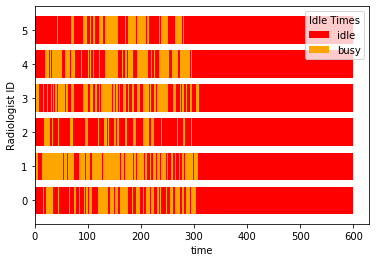

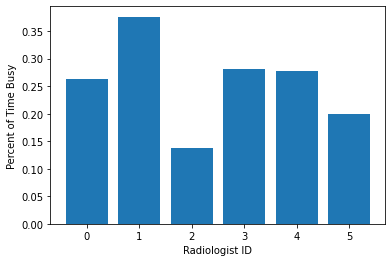

Radiologists were busy 0.256 of the time.
251 medical images
There are 0 that were not completed in time
Simulation complete at 600 minutes
Radiologist 0 was busy 0.282 of the time.
Radiologist 1 was busy 0.247 of the time.
Radiologist 2 was busy 0.329 of the time.
Radiologist 3 was busy 0.249 of the time.
Radiologist 4 was busy 0.189 of the time.
Radiologist 5 was busy 0.139 of the time.


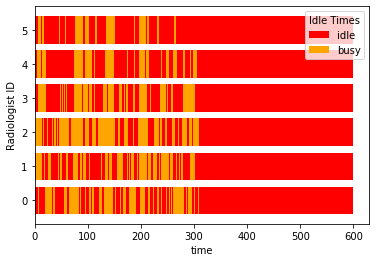

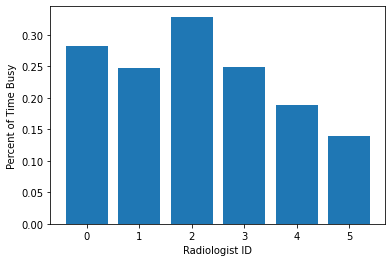

Radiologists were busy 0.239 of the time.
260 medical images
There are 0 that were not completed in time
Simulation complete at 600 minutes
Radiologist 0 was busy 0.243 of the time.
Radiologist 1 was busy 0.206 of the time.
Radiologist 2 was busy 0.393 of the time.
Radiologist 3 was busy 0.333 of the time.
Radiologist 4 was busy 0.041 of the time.
Radiologist 5 was busy 0.136 of the time.


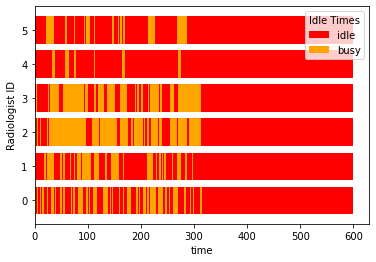

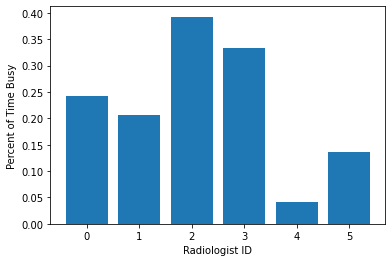

Radiologists were busy 0.225 of the time.
228 medical images
There are 0 that were not completed in time
Simulation complete at 600 minutes
Radiologist 0 was busy 0.334 of the time.
Radiologist 1 was busy 0.178 of the time.
Radiologist 2 was busy 0.239 of the time.
Radiologist 3 was busy 0.277 of the time.
Radiologist 4 was busy 0.246 of the time.
Radiologist 5 was busy 0.069 of the time.


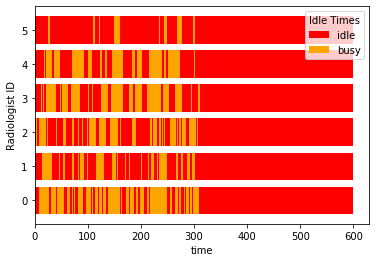

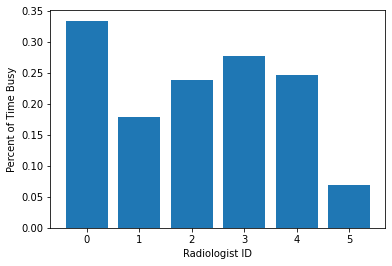

Radiologists were busy 0.224 of the time.
233 medical images
There are 0 that were not completed in time
Simulation complete at 600 minutes
Radiologist 0 was busy 0.344 of the time.
Radiologist 1 was busy 0.203 of the time.
Radiologist 2 was busy 0.351 of the time.
Radiologist 3 was busy 0.216 of the time.
Radiologist 4 was busy 0.183 of the time.
Radiologist 5 was busy 0.088 of the time.


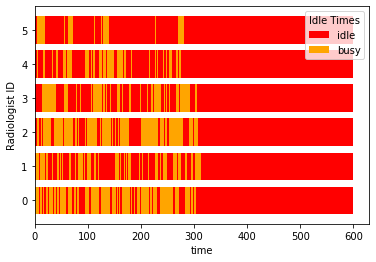

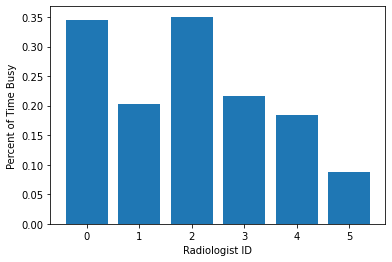

Radiologists were busy 0.231 of the time.
223 medical images
There are 0 that were not completed in time
Simulation complete at 600 minutes
Radiologist 0 was busy 0.293 of the time.
Radiologist 1 was busy 0.302 of the time.
Radiologist 2 was busy 0.185 of the time.
Radiologist 3 was busy 0.059 of the time.
Radiologist 4 was busy 0.192 of the time.
Radiologist 5 was busy 0.15 of the time.


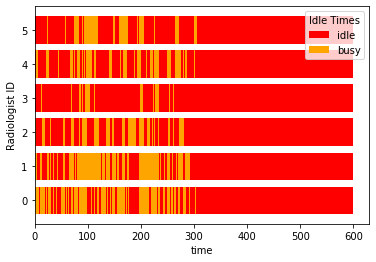

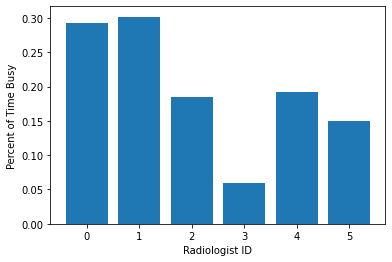

Radiologists were busy 0.197 of the time.
228 medical images
There are 0 that were not completed in time
Simulation complete at 600 minutes
Radiologist 0 was busy 0.274 of the time.
Radiologist 1 was busy 0.323 of the time.
Radiologist 2 was busy 0.256 of the time.
Radiologist 3 was busy 0.238 of the time.
Radiologist 4 was busy 0.085 of the time.
Radiologist 5 was busy 0.085 of the time.


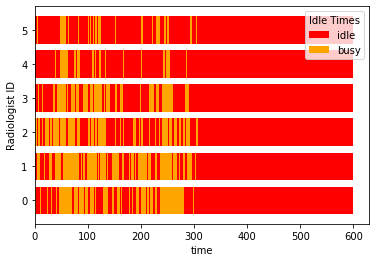

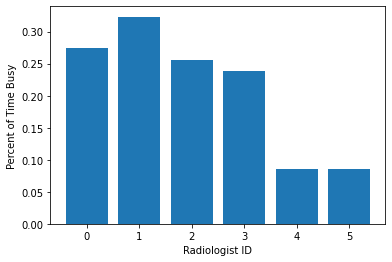

Radiologists were busy 0.21 of the time.
178 medical images
There are 0 that were not completed in time
Simulation complete at 600 minutes
Radiologist 0 was busy 0.317 of the time.
Radiologist 1 was busy 0.175 of the time.
Radiologist 2 was busy 0.153 of the time.
Radiologist 3 was busy 0.03 of the time.
Radiologist 4 was busy 0.192 of the time.
Radiologist 5 was busy 0.072 of the time.


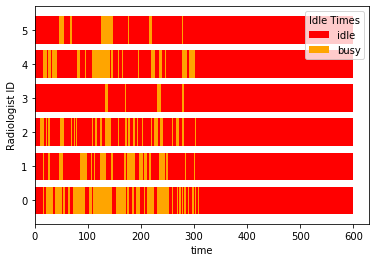

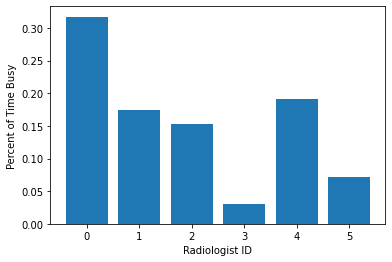

Radiologists were busy 0.157 of the time.
167 medical images
There are 0 that were not completed in time
Simulation complete at 600 minutes
Radiologist 0 was busy 0.278 of the time.
Radiologist 1 was busy 0.253 of the time.
Radiologist 2 was busy 0.177 of the time.
Radiologist 3 was busy 0.066 of the time.
Radiologist 4 was busy 0.067 of the time.
Radiologist 5 was busy 0.043 of the time.


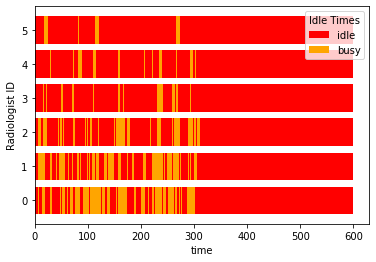

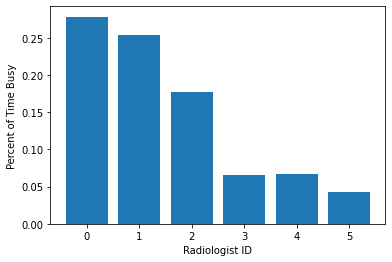

Radiologists were busy 0.147 of the time.
173 medical images
There are 0 that were not completed in time
Simulation complete at 600 minutes
Radiologist 0 was busy 0.246 of the time.
Radiologist 1 was busy 0.222 of the time.
Radiologist 2 was busy 0.197 of the time.
Radiologist 3 was busy 0.13 of the time.
Radiologist 4 was busy 0.092 of the time.
Radiologist 5 was busy 0.053 of the time.


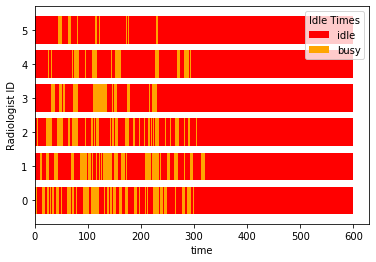

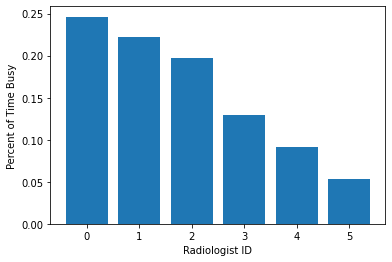

Radiologists were busy 0.156 of the time.
167 medical images
There are 0 that were not completed in time
Simulation complete at 600 minutes
Radiologist 0 was busy 0.252 of the time.
Radiologist 1 was busy 0.181 of the time.
Radiologist 2 was busy 0.226 of the time.
Radiologist 3 was busy 0.164 of the time.
Radiologist 4 was busy 0.059 of the time.
Radiologist 5 was busy 0.028 of the time.


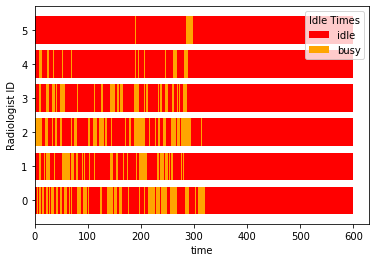

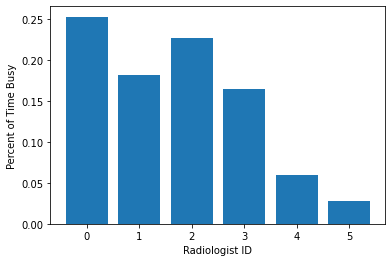

Radiologists were busy 0.152 of the time.
159 medical images
There are 0 that were not completed in time
Simulation complete at 600 minutes
Radiologist 0 was busy 0.317 of the time.
Radiologist 1 was busy 0.181 of the time.
Radiologist 2 was busy 0.184 of the time.
Radiologist 3 was busy 0.217 of the time.
Radiologist 4 was busy 0.066 of the time.
Radiologist 5 was busy 0.008 of the time.


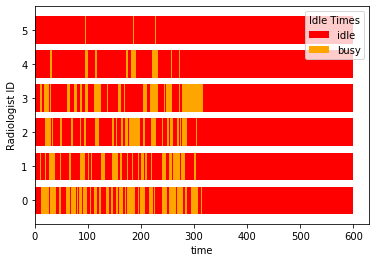

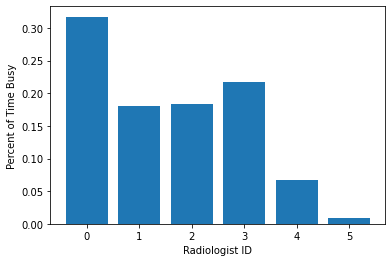

Radiologists were busy 0.162 of the time.
175 medical images
There are 0 that were not completed in time
Simulation complete at 600 minutes
Radiologist 0 was busy 0.311 of the time.
Radiologist 1 was busy 0.158 of the time.
Radiologist 2 was busy 0.245 of the time.
Radiologist 3 was busy 0.222 of the time.
Radiologist 4 was busy 0.082 of the time.
Radiologist 5 was busy 0.008 of the time.


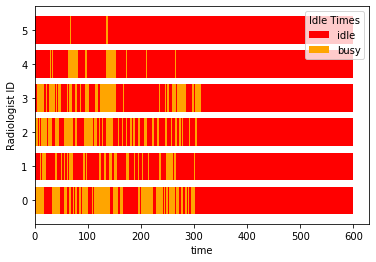

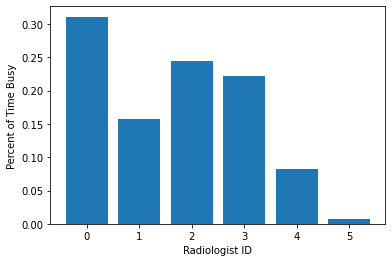

Radiologists were busy 0.171 of the time.
156 medical images
There are 0 that were not completed in time
Simulation complete at 600 minutes
Radiologist 0 was busy 0.305 of the time.
Radiologist 1 was busy 0.199 of the time.
Radiologist 2 was busy 0.142 of the time.
Radiologist 3 was busy 0.134 of the time.
Radiologist 4 was busy 0.047 of the time.
Radiologist 5 was busy 0.045 of the time.


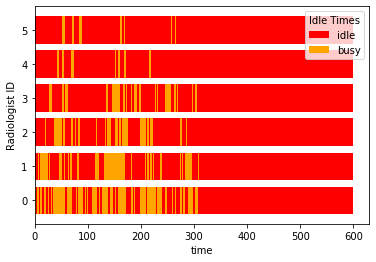

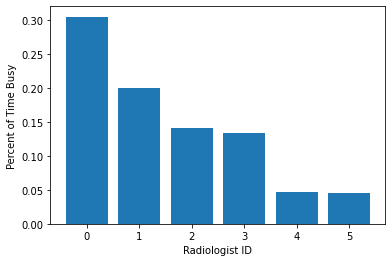

Radiologists were busy 0.145 of the time.
157 medical images
There are 0 that were not completed in time
Simulation complete at 600 minutes
Radiologist 0 was busy 0.316 of the time.
Radiologist 1 was busy 0.212 of the time.
Radiologist 2 was busy 0.148 of the time.
Radiologist 3 was busy 0.088 of the time.
Radiologist 4 was busy 0.032 of the time.
Radiologist 5 was busy 0.038 of the time.


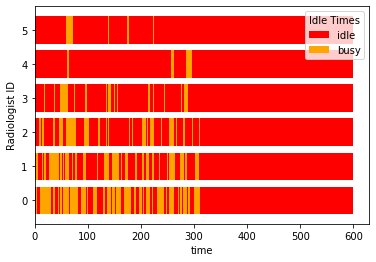

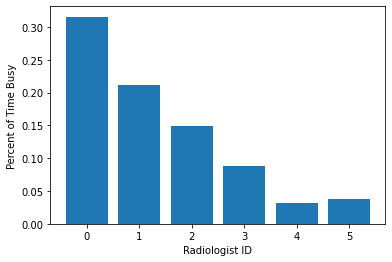

Radiologists were busy 0.139 of the time.
138 medical images
There are 0 that were not completed in time
Simulation complete at 600 minutes
Radiologist 0 was busy 0.26 of the time.
Radiologist 1 was busy 0.215 of the time.
Radiologist 2 was busy 0.195 of the time.
Radiologist 3 was busy 0.07 of the time.
Radiologist 4 was busy 0.037 of the time.
Radiologist 5 was busy 0.023 of the time.


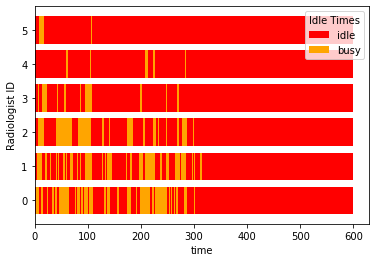

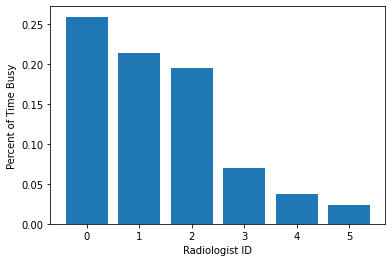

Radiologists were busy 0.133 of the time.
135 medical images
There are 0 that were not completed in time
Simulation complete at 600 minutes
Radiologist 0 was busy 0.245 of the time.
Radiologist 1 was busy 0.215 of the time.
Radiologist 2 was busy 0.163 of the time.
Radiologist 3 was busy 0.108 of the time.
Radiologist 4 was busy 0.014 of the time.
Radiologist 5 was busy 0.082 of the time.


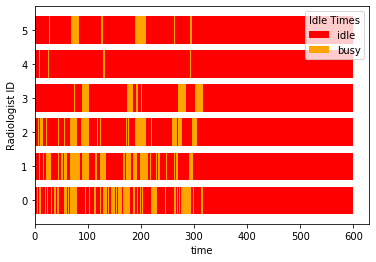

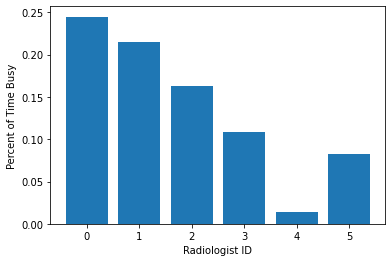

Radiologists were busy 0.138 of the time.
118 medical images
There are 0 that were not completed in time
Simulation complete at 600 minutes
Radiologist 0 was busy 0.211 of the time.
Radiologist 1 was busy 0.178 of the time.
Radiologist 2 was busy 0.127 of the time.
Radiologist 3 was busy 0.046 of the time.
Radiologist 4 was busy 0.045 of the time.
Radiologist 5 was busy 0.053 of the time.


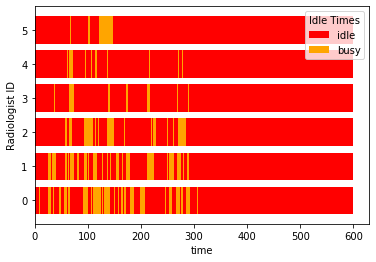

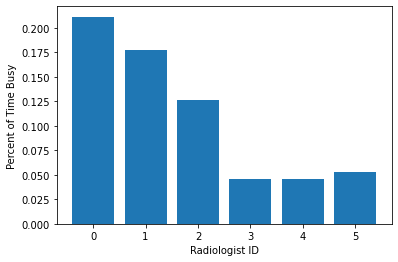

Radiologists were busy 0.11 of the time.
116 medical images
There are 0 that were not completed in time
Simulation complete at 600 minutes
Radiologist 0 was busy 0.171 of the time.
Radiologist 1 was busy 0.155 of the time.
Radiologist 2 was busy 0.034 of the time.
Radiologist 3 was busy 0.161 of the time.
Radiologist 4 was busy 0.026 of the time.
Radiologist 5 was busy 0.056 of the time.


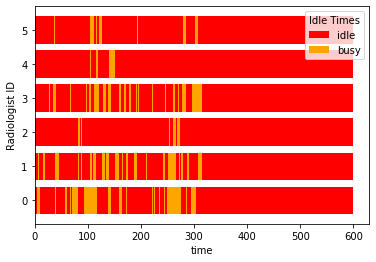

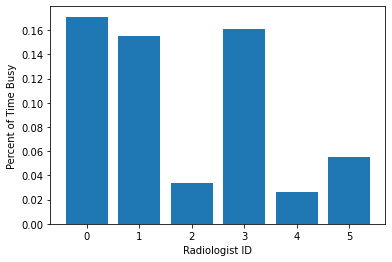

Radiologists were busy 0.1 of the time.
136 medical images
There are 0 that were not completed in time
Simulation complete at 600 minutes
Radiologist 0 was busy 0.275 of the time.
Radiologist 1 was busy 0.21 of the time.
Radiologist 2 was busy 0.184 of the time.
Radiologist 3 was busy 0.1 of the time.
Radiologist 4 was busy 0.087 of the time.
Radiologist 5 was busy 0.012 of the time.


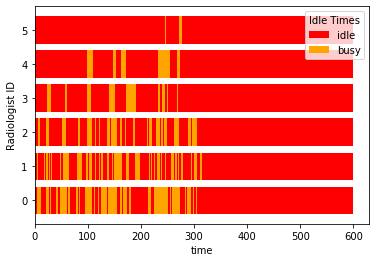

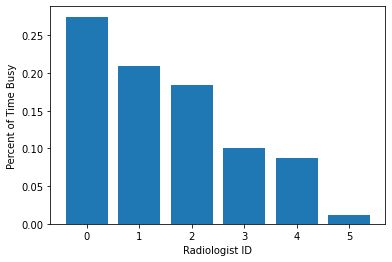

Radiologists were busy 0.145 of the time.
126 medical images
There are 0 that were not completed in time
Simulation complete at 600 minutes
Radiologist 0 was busy 0.165 of the time.
Radiologist 1 was busy 0.191 of the time.
Radiologist 2 was busy 0.075 of the time.
Radiologist 3 was busy 0.02 of the time.
Radiologist 4 was busy 0.049 of the time.
Radiologist 5 was busy 0.13 of the time.


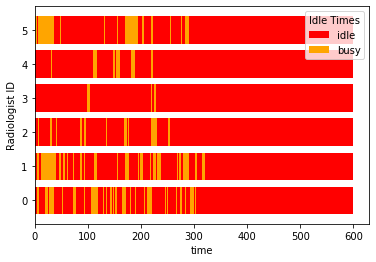

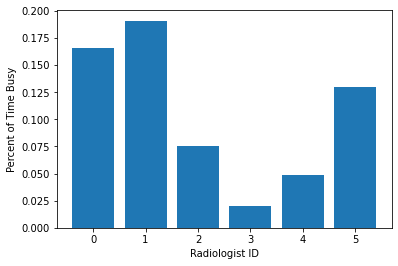

Radiologists were busy 0.105 of the time.
138 medical images
There are 0 that were not completed in time
Simulation complete at 600 minutes
Radiologist 0 was busy 0.251 of the time.
Radiologist 1 was busy 0.197 of the time.
Radiologist 2 was busy 0.133 of the time.
Radiologist 3 was busy 0.035 of the time.
Radiologist 4 was busy 0.091 of the time.
Radiologist 5 was busy 0.01 of the time.


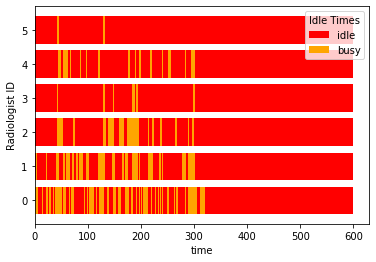

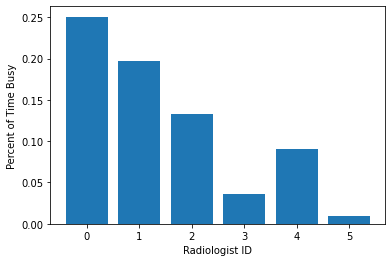

Radiologists were busy 0.119 of the time.
128 medical images
There are 0 that were not completed in time
Simulation complete at 600 minutes
Radiologist 0 was busy 0.273 of the time.
Radiologist 1 was busy 0.084 of the time.
Radiologist 2 was busy 0.087 of the time.
Radiologist 3 was busy 0.004 of the time.
Radiologist 4 was busy 0.254 of the time.
Radiologist 5 was busy 0.062 of the time.


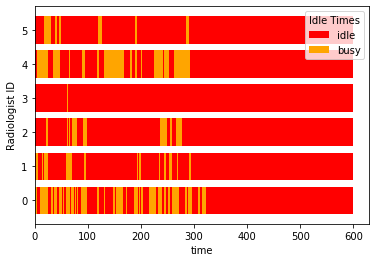

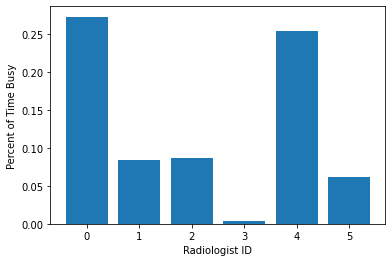

Radiologists were busy 0.127 of the time.
115 medical images
There are 0 that were not completed in time
Simulation complete at 600 minutes
Radiologist 0 was busy 0.208 of the time.
Radiologist 1 was busy 0.207 of the time.
Radiologist 2 was busy 0.082 of the time.
Radiologist 3 was busy 0.016 of the time.
Radiologist 4 was busy 0.096 of the time.
Radiologist 5 was busy 0.006 of the time.


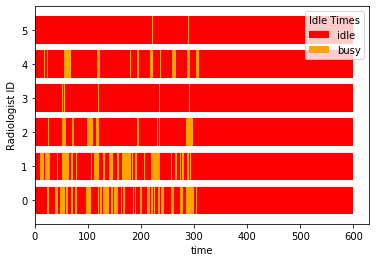

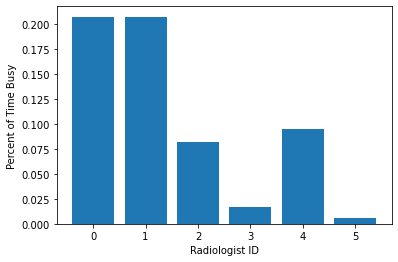

Radiologists were busy 0.102 of the time.


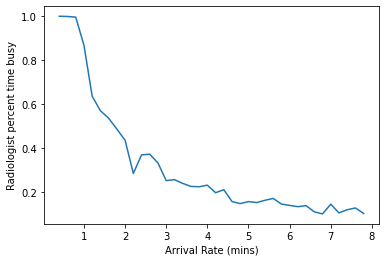

In [7]:
busy_times = {}
sims_dict = {}
for arr_rate_var in np.arange(0.4, 8.0, 0.1):
    #Define variables
    sim_time = 60*5
    rads_count = 6
    arr_rates = [arr_rate_var, arr_rate_var, arr_rate_var]
    urg_times = [2, 5, 10]
    #run sim
    s_temp = sim(sim_time, rads_count, arr_rates, urg_times, cutoff=True, verbose=False)
    
    busy_times[arr_rate_var] = idle_plots(s_temp.rads)
    sims_dict[arr_rate_var] = s_temp
plt.plot(busy_times.keys(), busy_times.values(), label=f"{rads_count} radiologists")
plt.xlabel("Arrival Rate: Image Every (mins)")
plt.ylabel("Radiologist percent time busy")
plt.title("Radiologist Time Busy for Varying Image Arrival Rate")
plt.show()

Time plots for images arriving avg every 0.4 mins


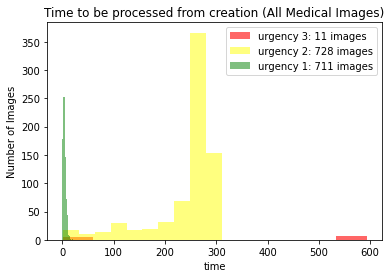

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 4.238386962745135
Urgency 2: 240.82422498726157
Urgency 3: 324.67097398651407


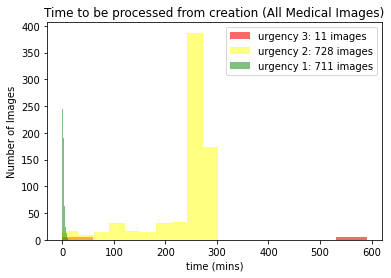

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.3339799134258903
Urgency 2: 237.8151496413206
Urgency 3: 321.5399349113776

_______________________________________________

Time plots for images arriving avg every 0.6 mins


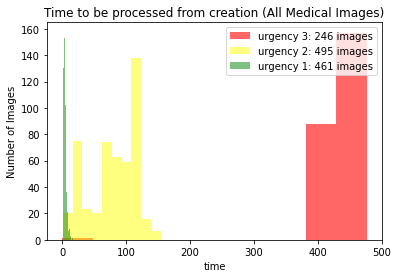

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 3.3537774993271707
Urgency 2: 79.19842448857207
Urgency 3: 433.7604377130544


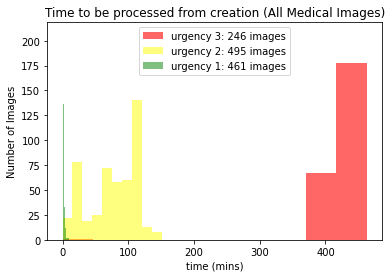

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.4678345084002877
Urgency 2: 76.13411562305993
Urgency 3: 428.8855074029669

_______________________________________________

Time plots for images arriving avg every 0.8 mins


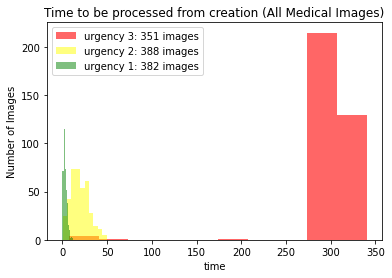

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 3.1021085005111266
Urgency 2: 19.687088730626538
Urgency 3: 300.6058077655069


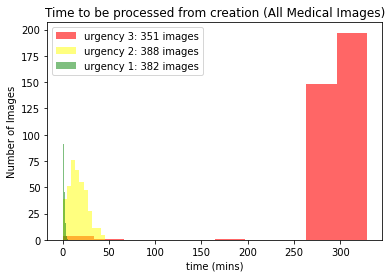

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.1392167012814831
Urgency 2: 16.705281126568924
Urgency 3: 295.92041302746605

_______________________________________________

Time plots for images arriving avg every 1.0 mins


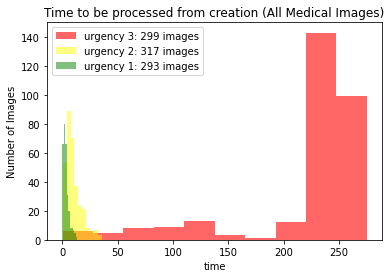

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 3.334986415673348
Urgency 2: 10.025710447232598
Urgency 3: 218.18064201669867


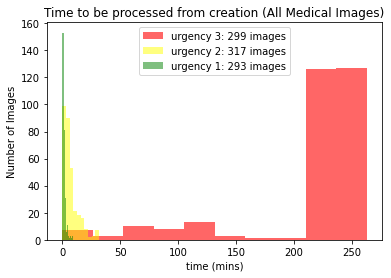

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.3154039930303587
Urgency 2: 6.940529204473168
Urgency 3: 212.9799116067699

_______________________________________________

Time plots for images arriving avg every 1.2 mins


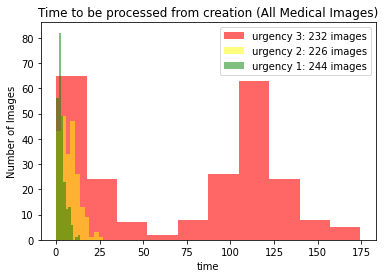

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 3.168984609634106
Urgency 2: 7.658008295062132
Urgency 3: 73.0079946571517


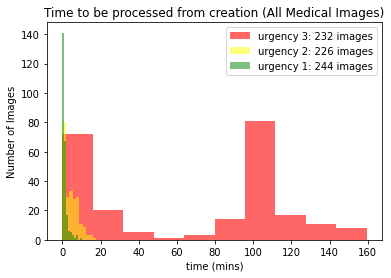

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.2813263730666042
Urgency 2: 4.4411785252776275
Urgency 3: 67.87427126884226

_______________________________________________

Time plots for images arriving avg every 1.4 mins


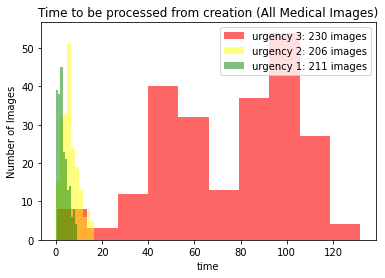

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 3.072252433256673
Urgency 2: 6.260904127060876
Urgency 3: 75.19416105408244


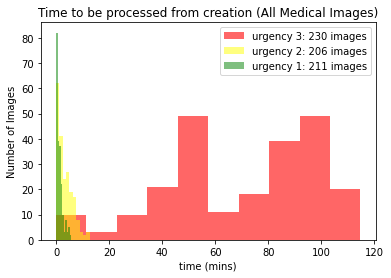

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.225565513839383
Urgency 2: 3.2935021747947784
Urgency 3: 69.85245273370899

_______________________________________________

Time plots for images arriving avg every 1.6 mins


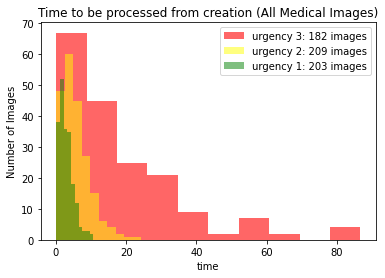

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.9688800334739804
Urgency 2: 5.580505379989666
Urgency 3: 18.382700638418225


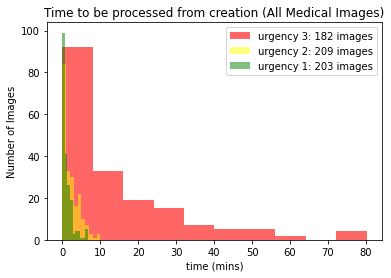

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.1922037805982653
Urgency 2: 2.2363779535681787
Urgency 3: 14.082609783736313

_______________________________________________

Time plots for images arriving avg every 1.8 mins


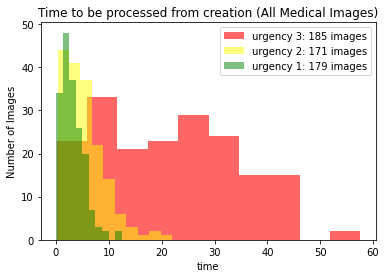

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 3.120007739297988
Urgency 2: 5.347825770880759
Urgency 3: 21.51233472232296


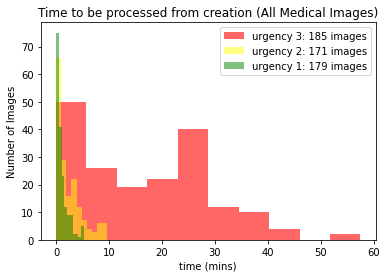

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.038613264826782
Urgency 2: 2.4222581149592037
Urgency 3: 16.690863228763227

_______________________________________________

Time plots for images arriving avg every 2.0 mins


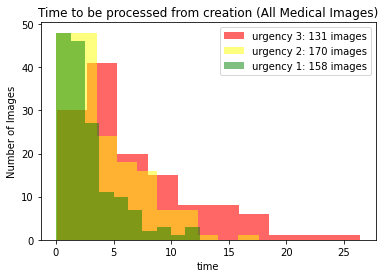

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.813508781087712
Urgency 2: 4.06150093614447
Urgency 3: 6.477695104214863


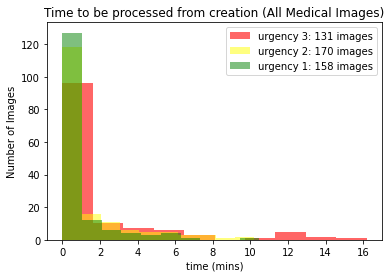

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.8010606612656053
Urgency 2: 1.276617420797665
Urgency 3: 1.8384317308248437

_______________________________________________

Time plots for images arriving avg every 2.2 mins


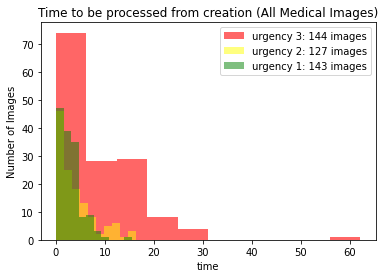

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.9052479821503416
Urgency 2: 4.05985826231436
Urgency 3: 8.57695176505686


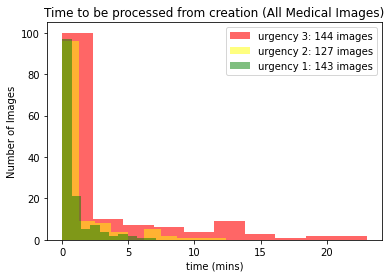

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.8123961770526218
Urgency 2: 1.2756013620887308
Urgency 3: 3.1481176661833907

_______________________________________________

Time plots for images arriving avg every 2.4 mins


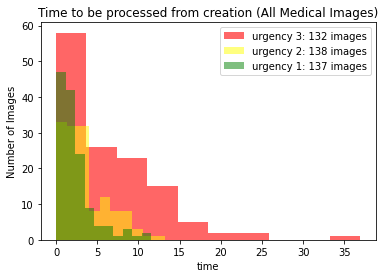

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.241881832849776
Urgency 2: 3.46448175385181
Urgency 3: 6.301254459865904


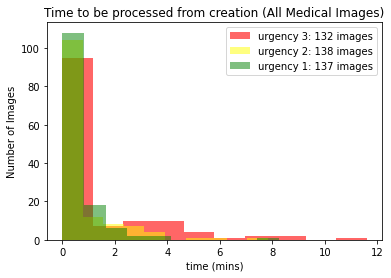

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.48244447719551814
Urgency 2: 0.6375898317634836
Urgency 3: 1.2286699322425318

_______________________________________________

Time plots for images arriving avg every 2.6 mins


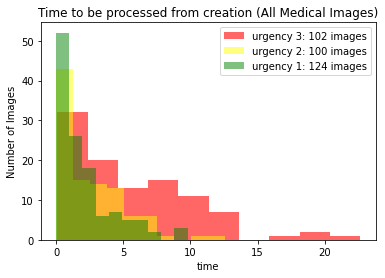

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.0837912197318027
Urgency 2: 2.5861202728968067
Urgency 3: 5.692054127211826


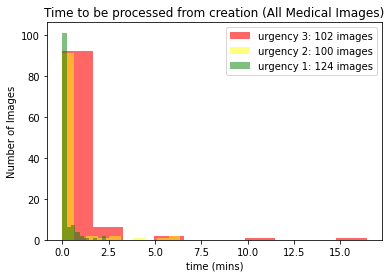

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.15339796256010393
Urgency 2: 0.3567116397958654
Urgency 3: 0.5677261461601573

_______________________________________________

Time plots for images arriving avg every 2.8 mins


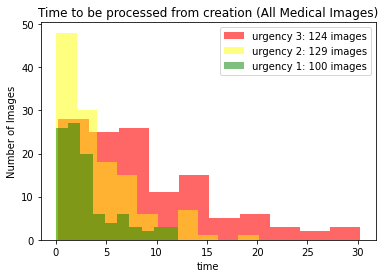

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 3.1908218875308756
Urgency 2: 4.2618106586970255
Urgency 3: 8.679741222588596


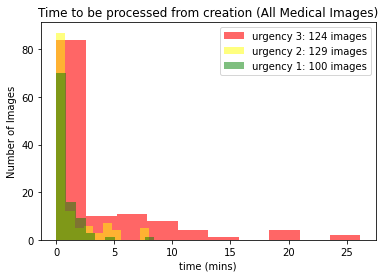

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.6877682373341207
Urgency 2: 1.1532260739332585
Urgency 3: 3.2752153080598605

_______________________________________________

Time plots for images arriving avg every 3.0 mins


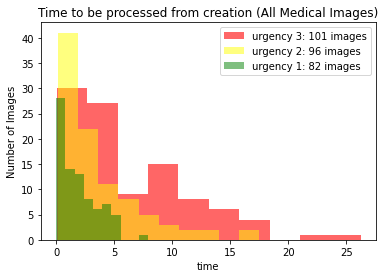

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.9214769176814055
Urgency 2: 3.604291919314146
Urgency 3: 6.460215186983288


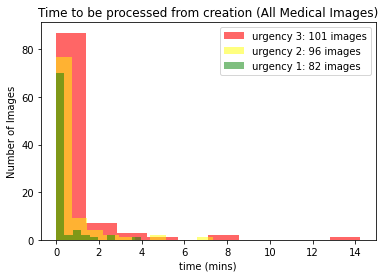

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.2497425882501618
Urgency 2: 0.47441367731431683
Urgency 3: 0.6645075940410154

_______________________________________________

Time plots for images arriving avg every 3.2 mins


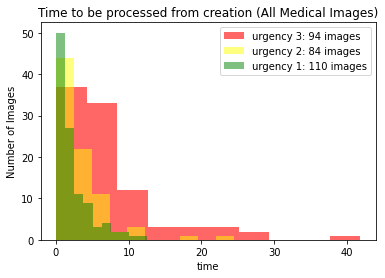

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.317102232611169
Urgency 2: 3.2908004584413235
Urgency 3: 6.899358878698513


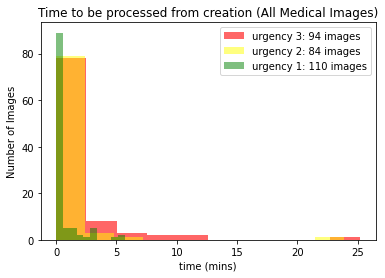

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.47943763825752717
Urgency 2: 0.6780638956405711
Urgency 3: 1.3423465833719554

_______________________________________________

Time plots for images arriving avg every 3.4 mins


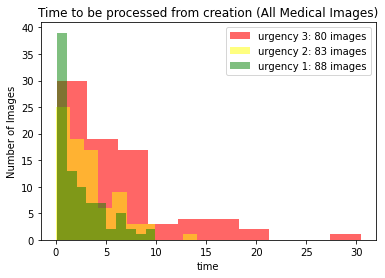

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.329913700287315
Urgency 2: 3.2074889880516064
Urgency 3: 5.991249114796054


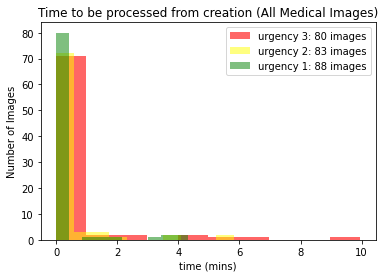

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.27707622784159336
Urgency 2: 0.35747325727008883
Urgency 3: 0.5195702263953319

_______________________________________________

Time plots for images arriving avg every 3.6 mins


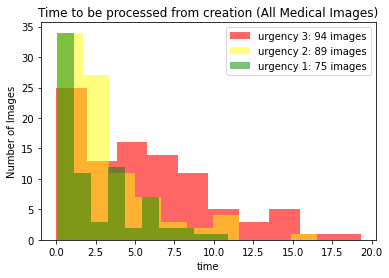

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.5150298831177835
Urgency 2: 3.163877687087916
Urgency 3: 5.467495654898762


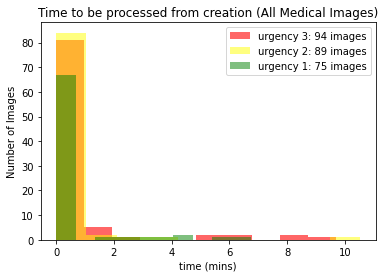

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.43995930899319013
Urgency 2: 0.2795591341213088
Urgency 3: 0.6581608981365401

_______________________________________________

Time plots for images arriving avg every 3.8 mins


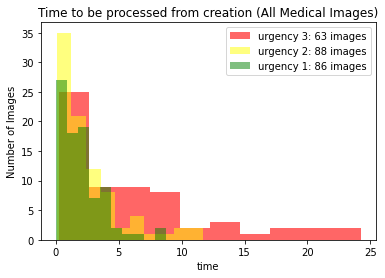

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.970002516242864
Urgency 2: 2.517437721132146
Urgency 3: 6.135545094809445


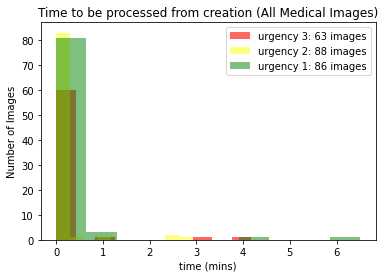

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.17749583767739674
Urgency 2: 0.10757915490571547
Urgency 3: 0.1299690766321919

_______________________________________________

Time plots for images arriving avg every 4.0 mins


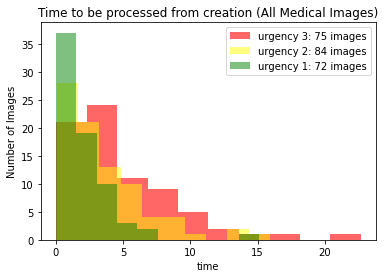

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.1175958036385083
Urgency 2: 3.5306599393266733
Urgency 3: 4.775981032532396


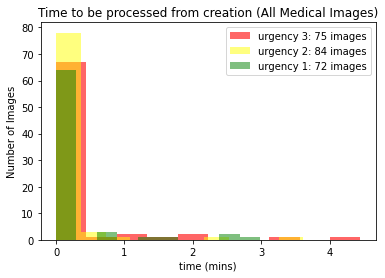

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.1897114959605951
Urgency 2: 0.11139226266098456
Urgency 3: 0.22214099702571738

_______________________________________________

Time plots for images arriving avg every 4.2 mins


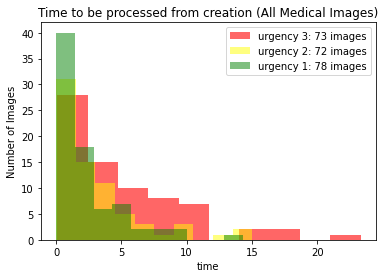

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.3159034662554276
Urgency 2: 3.1006642504011346
Urgency 3: 5.175236242140846


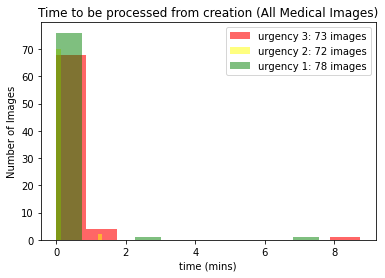

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.13556597038168733
Urgency 2: 0.03709296948507972
Urgency 3: 0.20569102343427884

_______________________________________________

Time plots for images arriving avg every 4.4 mins


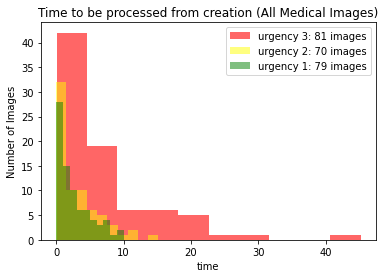

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.5681910453581573
Urgency 2: 3.05186914316098
Urgency 3: 7.060612543936534


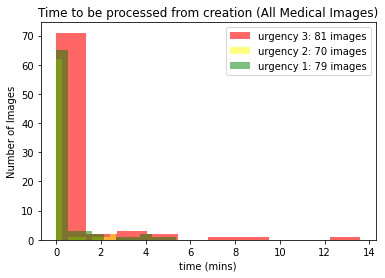

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.4376853994446075
Urgency 2: 0.20440174947425838
Urgency 3: 0.6619692205083396

_______________________________________________

Time plots for images arriving avg every 4.6 mins


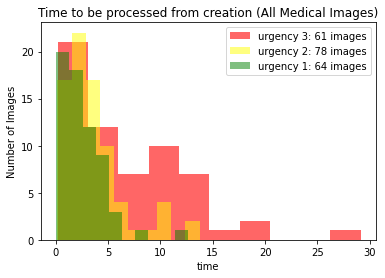

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.4699201343491732
Urgency 2: 3.50181405725561
Urgency 3: 6.763794195262839


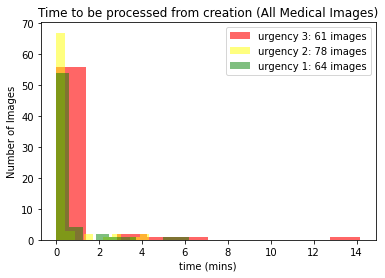

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.39621071703212074
Urgency 2: 0.34364291246414014
Urgency 3: 0.5458609130669915

_______________________________________________

Time plots for images arriving avg every 4.8 mins


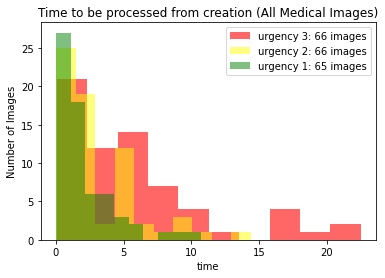

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.0910431385897894
Urgency 2: 2.9132146188363492
Urgency 3: 5.730384445453404


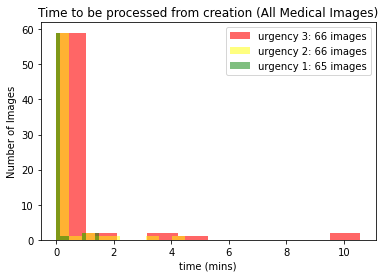

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.08483318773769388
Urgency 2: 0.22109474022645384
Urgency 3: 0.56988189625915

_______________________________________________

Time plots for images arriving avg every 5.0 mins


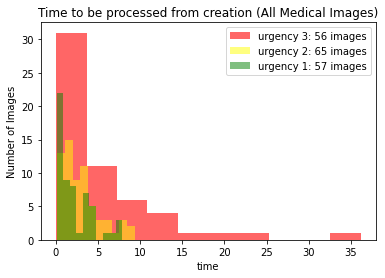

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.1038513717790805
Urgency 2: 3.039803133357735
Urgency 3: 5.310720563175073


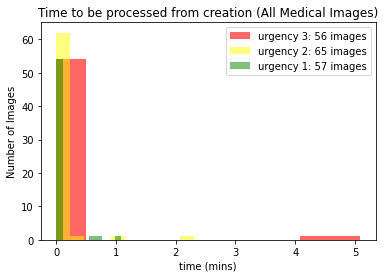

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.042783860569794496
Urgency 2: 0.05874650099788562
Urgency 3: 0.17707620826504286

_______________________________________________

Time plots for images arriving avg every 5.2 mins


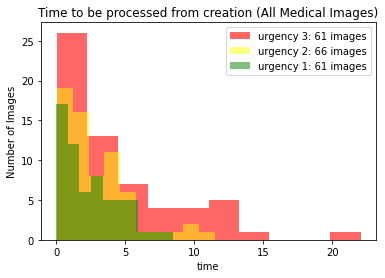

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.4464026205296547
Urgency 2: 2.874849857118428
Urgency 3: 4.481941055199312


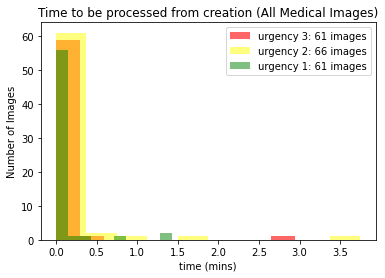

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.07036295547994086
Urgency 2: 0.11414086484990535
Urgency 3: 0.05408502312955722

_______________________________________________

Time plots for images arriving avg every 5.4 mins


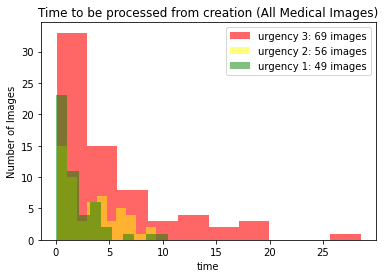

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.027987136456037
Urgency 2: 3.1639556970709846
Urgency 3: 5.343791473863327


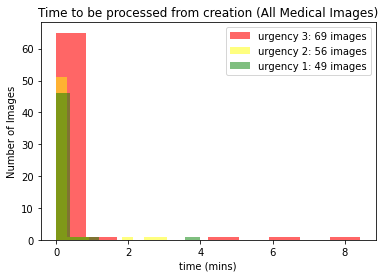

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.11176377195674286
Urgency 2: 0.15453846601467675
Urgency 3: 0.29632996567523107

_______________________________________________

Time plots for images arriving avg every 5.6 mins


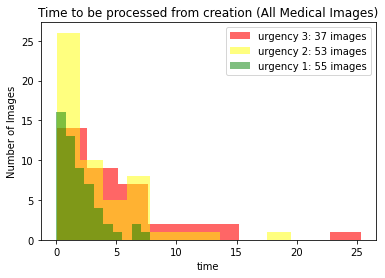

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.8771781129608538
Urgency 2: 3.37990601436131
Urgency 3: 4.83185498726776


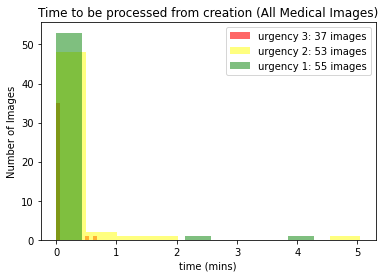

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.12012358108108649
Urgency 2: 0.17443693968999804
Urgency 3: 0.031848530203563076

_______________________________________________

Time plots for images arriving avg every 5.8 mins


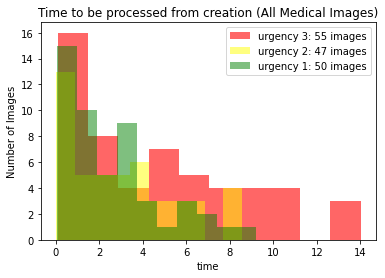

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.5224960861156682
Urgency 2: 3.0114835752546933
Urgency 3: 4.642972530578423


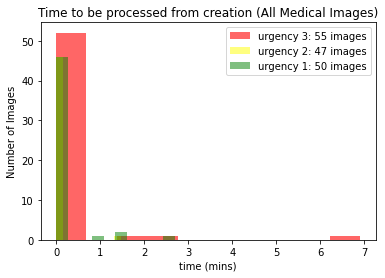

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.13451272613979712
Urgency 2: 0.03133235691964721
Urgency 3: 0.20172472723080623

_______________________________________________



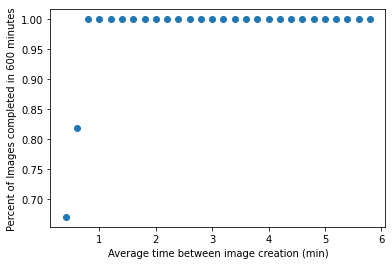

In [69]:
for arr_val, s in sims_dict.items():
    print(f"Time plots for images arriving avg every {round(arr_val,2)} mins")
    total_time_hist(s)
    wait_time_hist(s)
    print("")
    print("_______________________________________________")
    print("")
    
completion_plot(sims_dict)

In [ ]:
@app.callback(Output('call-wait-time-graph', 'figure'),
              [Input('agent_table', 'children'),
               Input('live-update-graph', 'hoverData')])
def wait_time_graph(rad_table, time_filter):
    '''
    '''
    agent_table_df = pd.read_json(agent_table_json, orient='split')
    #print('agent_table: ', agent_table_df_orig)
    
    current_hover = None
    if time_filter is not None:
        if time_filter['points'][0]['customdata'] != 'showall':
            current_hover = dt.datetime.strptime(time_filter['points'][0]['customdata'], "%Y-%m-%d %H:%M:%S")
    
    if current_hover is not None:
            agent_table_df = agent_table_df[agent_table_df['intvl_time_elapsed'] == cgd.timeElapsed(current_hover)].reset_index()

    traces=[]
    colorlist = []
    
    for x in agent_table_df['call_wait_time_elapsed'].tolist():
        if x > 60:
            colorlist.append('rgb(244,109,67)') #Red
        else:
            colorlist.append('rgb(128,205,193)') #Green
            
    traces.append(go.Scatter(
            x=agent_table_df['call_handle_start_time'],
            y=agent_table_df['call_wait_time_elapsed'],
            mode='markers', 
            marker={'color': colorlist, 'opacity': 0.8, 'line': {'width': 0.5, 'color': 'white'}},
            name=''))
    
    return {
        'data': traces,
        'layout': go.Layout(
            height=225,
            margin=margin,
            title="Avg. Call Wait Time: {:.2f} sec".format(round(sum(agent_table_df['call_wait_time_elapsed'])/float(len(agent_table_df))),2),
            xaxis={'zeroline': False},
            yaxis={'title': '', 'range':[0, max(agent_table_df['call_wait_time_elapsed'])*1.1], 'zeroline': False},
            hovermode='closest',
            font=dict(family='Raleway')
        )
    }